In [1]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['hatch.linewidth'] = 0.3  # pdf hatch linewidth
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy import stats
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [2]:
'''Read in required paleo archive data and calculate the nearest DO event to each speleothem transitions'''

NGRIP_Starts = pd.read_csv('Proxy_Data/NGRIP_StartOfGImainmain.txt',
                           delimiter='\t', header=None)  #Rasmussen et al. (2014) dates for DO events
NGRIP_Starts.columns = ['Event', 'Age / Years Before Present']

NGRIP_dO18 = pd.read_csv('Proxy_Data/NGRIP.txt', delimiter='\t', header=0) #NGRIP dO18 from Andersen et al. (2004)
dO18_change = np.empty(24)
for i in range(24): #Calculate NGRIP stadial-interstadial dO18 difference consistent with Fohlmeister et al. (2023) approach
    before = NGRIP_dO18.where((NGRIP_Starts['Age / Years Before Present'].loc[i]<NGRIP_dO18['Age (years b2k)']) \
                        & (NGRIP_dO18['Age (years b2k)']<NGRIP_Starts['Age / Years Before Present'].loc[i]+200)).dropna()
    after = NGRIP_dO18.where((NGRIP_dO18['Age (years b2k)']<NGRIP_Starts['Age / Years Before Present'].loc[i]) \
                        & (NGRIP_Starts['Age / Years Before Present'].loc[i]-200<NGRIP_dO18['Age (years b2k)'])).dropna()
    dO18_change[i] = np.mean(after['d18O(permil)']) - np.mean(before['d18O(permil)'])
NGRIP_Starts['dO18 Change / permil'] = dO18_change

NGRIP_T = pd.read_csv('Proxy_Data/NGRIP_Temperature_N15_Kindler.csv', header=0) #NGRIP temperature from Kindler et al. (2014)
T_change = np.empty(24)
for i in range(24): #Calculate NGRIP stadial-interstadial temperature difference consistent with Fohlmeister et al. (2023) approach
    before = NGRIP_T.where((NGRIP_Starts['Age / Years Before Present'].loc[i]<NGRIP_T['age GICC05modelext [yr]']) \
                        & (NGRIP_T['age GICC05modelext [yr]']<NGRIP_Starts['Age / Years Before Present'].loc[i]+200)).dropna()
    after = NGRIP_T.where((NGRIP_T['age GICC05modelext [yr]']<NGRIP_Starts['Age / Years Before Present'].loc[i]) \
                        & (NGRIP_Starts['Age / Years Before Present'].loc[i]-200<NGRIP_T['age GICC05modelext [yr]'])).dropna()
    T_change[i] = np.mean(after['temperature [°C]']) - np.mean(before['temperature [°C]'])
NGRIP_Starts['Temperature Change / K'] = T_change

stack_offset_events_tau = pd.read_csv('Proxy_Data/stack_offset_events_tau.csv') #Speleothem d18O transitions from Fohlmeister et al. (2023)
stack_offset_events_tau = stack_offset_events_tau[['entity_id','site_id', 'number', 'mean_off18O', 'new_region']]
stack_offset_events_tau = stack_offset_events_tau.dropna()

#Find the DO event from the Rasmussen et al. (2014) stratigraphy that is closest in time to each speleothem transition
DO_Event = np.full(len(stack_offset_events_tau),np.nan,dtype='object')
DO_Age = np.full(len(stack_offset_events_tau),np.nan,dtype='object')
DO_Temp = np.full(len(stack_offset_events_tau),np.nan,dtype='object')
DO_dO18 = np.full(len(stack_offset_events_tau),np.nan,dtype='object')
for i, stal_event_age in enumerate(stack_offset_events_tau['number'].values):
    DO_df = NGRIP_Starts.iloc[(NGRIP_Starts['Age / Years Before Present'] - stal_event_age).abs().argsort()[0]]
    DO_Event[i] = DO_df['Event']
    DO_Age[i] = DO_df['Age / Years Before Present']
    DO_Temp[i] = DO_df['Temperature Change / K']
    DO_dO18[i] = DO_df['dO18 Change / permil']
stack_offset_events_tau['DO Event'] = DO_Event
stack_offset_events_tau['DO Age / Years Before Present'] = DO_Age
stack_offset_events_tau['DO Temperature Difference / K'] = DO_Temp
stack_offset_events_tau['DO dO18 Change / permil'] = DO_dO18

#Split speleothems into six regions as shown in Figure 3
new_region_list = np.array(('Europe / Mediterranean','Western North America',
                            'Central America','South America','Asia','Oceania', 'Other'),dtype='str')
Speleothem_Ages = np.full((200,6,),np.nan)
Speleothem_Delta_T = np.full((200,6,),np.nan)
Speleothem_Delta_dO18 = np.full((200,6,),np.nan)
for i in range(6):
    new_region_df = stack_offset_events_tau.where(stack_offset_events_tau['new_region']==float(i+1)).dropna()
    Speleothem_Ages[:len(new_region_df),i] = new_region_df['DO Age / Years Before Present']
    Speleothem_Delta_T[:len(new_region_df),i] = new_region_df['DO Temperature Difference / K']
    Speleothem_Delta_dO18[:len(new_region_df),i] = new_region_df['DO dO18 Change / permil']

Mean / Median NGRIP Temperature Difference is 7.669742516680916 / 8.468181818181826
Mean / Median NGRIP dO18 Difference is 3.3426674061749035  / 3.4366666666666674


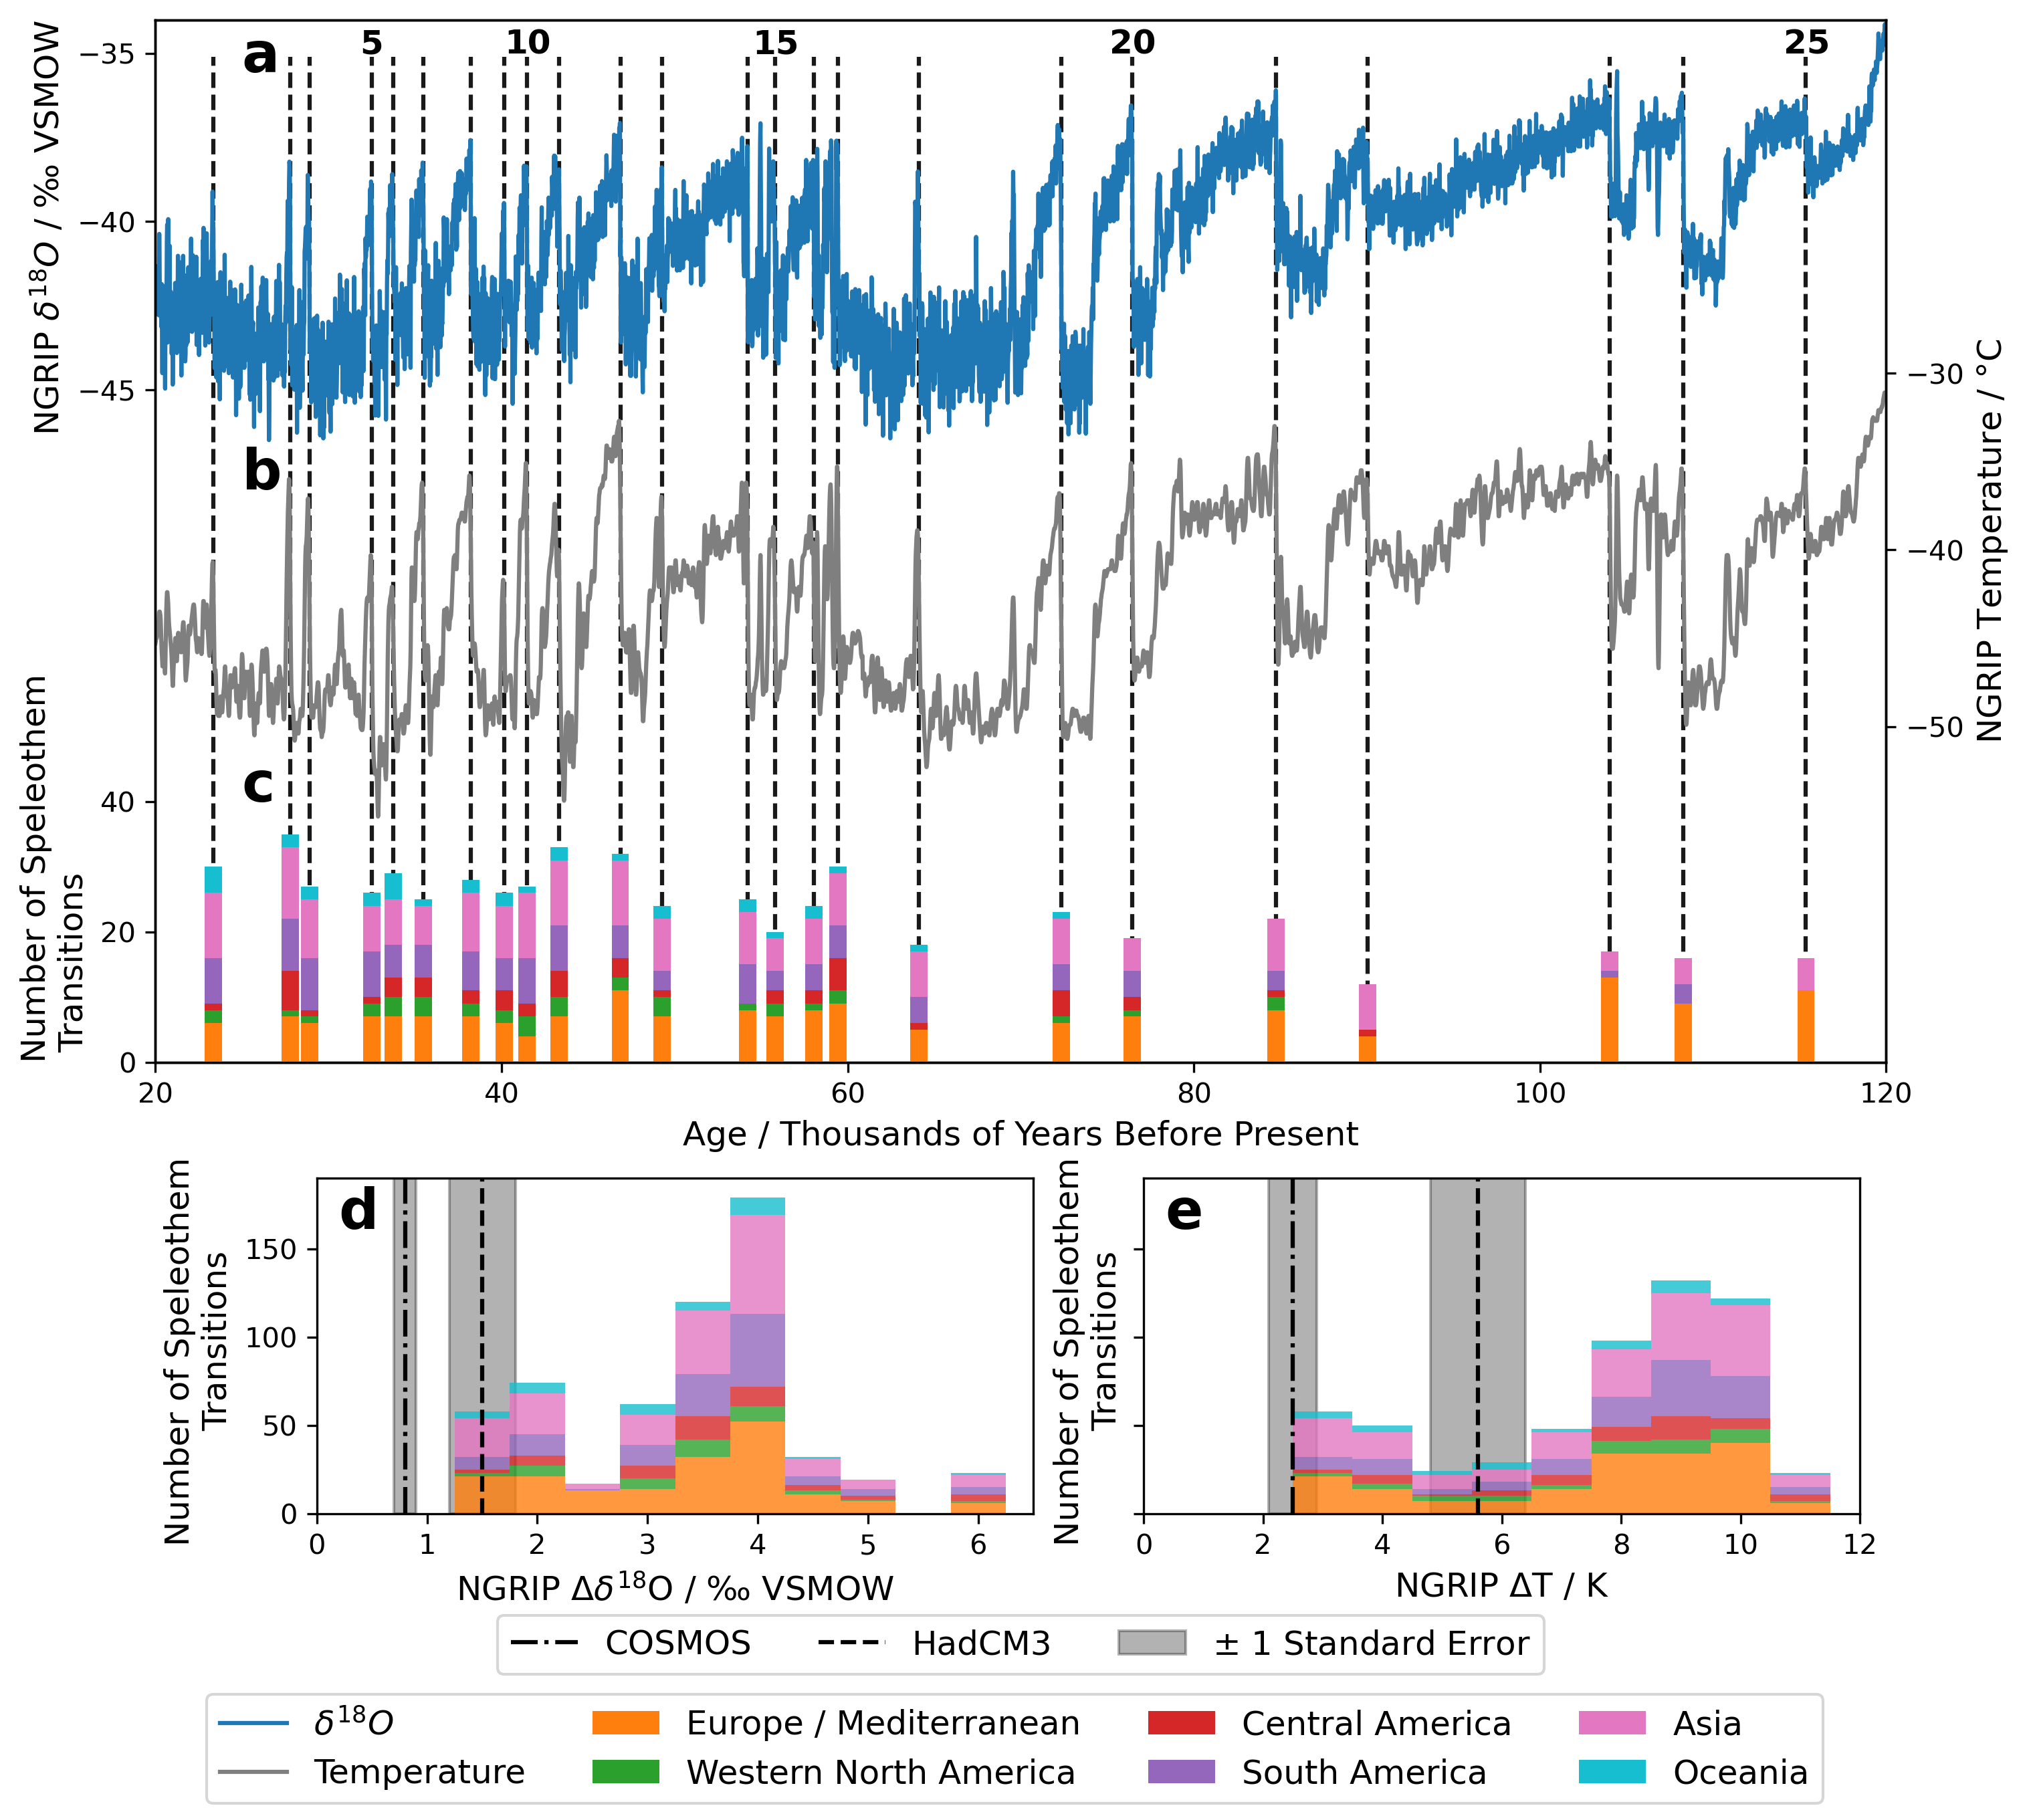

In [3]:
#Create Figure 1

fig, (ax1,ax4) = plt.subplots(nrows=2, height_ratios=(2,1), figsize=(10,9), layout='constrained')
dO18_plot = ax1.plot(NGRIP_dO18['Age (years b2k)']/1000, NGRIP_dO18['d18O(permil)'], color='tab:blue', label='$\delta^{18}O$')

#(a) NGRIP d18O
ax1.set_ylim((-65,-34))
ax1.set_xlim((20,120))
ax1.set_xlabel('Age / Thousands of Years Before Present',fontsize=12)
ax1.set_ylabel('NGRIP $\delta ^{18}O$ / ‰ VSMOW',fontsize=12,loc='top')
ax1.set_yticks((-45,-40,-35))
ax1.vlines(x=NGRIP_Starts['Age / Years Before Present']/1000,ymin=-65,ymax=-35.1,ls='--',alpha=0.9,colors='black',zorder=-10)
ax1.annotate('a', (0.05,0.95), xycoords='axes fraction', size=20, weight='bold', )
ax1.annotate(str(5), ((NGRIP_Starts['Age / Years Before Present'].loc[3]-700)/1000,-35), size=12, weight='bold', zorder=20)
for i in np.arange(10,30,step=5):
    ax1.annotate(str(i), ((NGRIP_Starts['Age / Years Before Present'].loc[i-2]-1300)/1000,-35), size=12, weight='bold', zorder=20)

#(b) NGRIP temperature
ax2 = ax1.twinx()
ax2.set_ylim((-69,-10))
temp_plot = ax2.plot(NGRIP_T['age GICC05modelext [yr]']/1000,NGRIP_T['temperature [°C]'], color='tab:grey', label = 'Temperature')
ax2.set_ylabel('NGRIP Temperature / $\degree$C',fontsize=12,loc='center')
ax2.set_yticks((-50,-40,-30))
ax2.tick_params(left=False,right=True)
ax2.annotate('b', (0.05,0.55), xycoords='axes fraction', size=20, weight='bold', )

#(c) Distribution of speleothem transitions
ax3 = ax1.twinx()
ax3.set_ylim((0,160))
ax3.set_yticks((0,20,40))
ax3.yaxis.set_label_position("left")
ax3.tick_params(left=True,right=False,labelleft=True,labelright=False)
ax3.set_ylabel('Number of Speleothem \n Transitions',fontsize=12,loc='bottom')
bins = np.sort(np.append(np.array(NGRIP_Starts['Age / Years Before Present'].values-500),
                          np.array(NGRIP_Starts['Age / Years Before Present'].values+500)))/1000
hist = ax3.hist(Speleothem_Ages/1000, bins = bins, label=new_region_list, stacked=True,
               color = ('tab:orange','tab:green','tab:red','tab:purple','tab:pink','tab:cyan'))
ax2.annotate('c', (0.05,0.25), xycoords='axes fraction', size=20, weight='bold', )

fig.legend(loc='outside lower center', fontsize='12', ncols=4)

#(e) NGRIP d18O increase associated with speleothem transitions
ax4.remove()
ss = ax4.get_subplotspec()
subfig = fig.add_subfigure(ss)
axs = subfig.subplots(1, 2, sharey=True)
bins = np.arange(0.25,6.5,step=0.5)
hist1 = axs[0].hist(Speleothem_Delta_dO18, bins=bins, color = ('tab:orange','tab:green','tab:red','tab:purple','tab:pink','tab:cyan'),
                    stacked=True, label=None, alpha=0.8)
axs[0].set_xlim((0,6.5))
axs[0].set_ylim((0,190))
axs[0].set_xlabel('NGRIP $\Delta$$\delta ^{18}$O / ‰ VSMOW',fontsize=12)
axs[0].set_ylabel('Number of Speleothem \n Transitions',fontsize=12)
axs[0].axvline(0.8,ls='-.',label=None,color='black')
axs[0].fill_betweenx(y=(0,190),x1=0.7,x2=0.9,color='black',alpha=0.3,zorder=-10)
axs[0].axvline(1.5,ls='--',label=None,color='black')
axs[0].fill_betweenx(y=(0,190),x1=1.2,x2=1.8,color='black',alpha=0.3,zorder=-10)
axs[0].annotate('d', (0.03,0.85), xycoords='axes fraction', size=20, weight='bold', )

#(f) NGRIP temperature increase associated with speleothem transitions
bins = np.arange(0.5,12.5)
hist2 = axs[1].hist(Speleothem_Delta_T, bins=bins, color = ('tab:orange','tab:green','tab:red','tab:purple','tab:pink','tab:cyan'),
                    stacked=True, label=None, alpha=0.8)
axs[1].set_xlim((0,12))
axs[1].set_ylim((0,190))
axs[1].set_xlabel('NGRIP $\Delta$T / K',fontsize=12)
axs[1].set_ylabel('Number of Speleothem \n Transitions',fontsize=12)
COSMOS = axs[1].axvline(2.5,ls='-.',label='COSMOS',color='black')
axs[1].fill_betweenx(y=(0,190),x1=2.1,x2=2.9,color='black',alpha=0.3,zorder=-10)
HadCM3 = axs[1].axvline(5.6,ls='--',label='HadCM3',color='black')
axs[1].fill_betweenx(y=(0,190),x1=4.8,x2=6.4,color='black',alpha=0.3,zorder=-10,label='$\pm$ 1 Standard Error')
axs[1].annotate('e', (0.03,0.85), xycoords='axes fraction', size=20, weight='bold', )


print('Mean / Median NGRIP Temperature Difference is '+str(np.mean(stack_offset_events_tau['DO Temperature Difference / K'].values))+ ' / ' \
        +str(np.median(stack_offset_events_tau['DO Temperature Difference / K'].values)))
print('Mean / Median NGRIP dO18 Difference is ' +str(np.mean(stack_offset_events_tau['DO dO18 Change / permil'].values))+'  / ' \
        +str(np.median(stack_offset_events_tau['DO dO18 Change / permil'].values)))

subfig.legend(loc='outside lower center', fontsize='12', ncols=3)

plt.savefig('Figures/Fig1.pdf')

In [4]:
stal = pd.read_csv('Proxy_Data/stack_offset_stal_tau.csv',header=0) #Speleothem transitions from Fohlmeister et al. (2023)
stal['longitude'] = (stal['longitude']-360)%360
stal['median_off18O'] = - stal['median_off18O']

In [5]:
'''Read model fields for COSMOS temperature'''
COSMOS_temp_mean = xr.open_dataarray('COSMOS_Data/Mean_temp.nc') #Mean over whole run
COSMOS_Delta_temp_max = xr.open_dataarray('COSMOS_Data/Max_Delta_temp.nc') #Stadial-Interstadial difference under narrowest definitions
COSMOS_Delta_temp_min = xr.open_dataarray('COSMOS_Data/Min_Delta_temp.nc') #Stadial-Interstadial difference under widest definitions
COSMOS_Delta_temp = (COSMOS_Delta_temp_max+COSMOS_Delta_temp_min)/2 #Take average of max and min values to give central estimate
COSMOS_Delta_temp_err = (COSMOS_Delta_temp_max-COSMOS_Delta_temp_min)/(2*np.sqrt(2)) #Calculate error due to uncertainty in definitions
COSMOS_temp_stadial = COSMOS_temp_mean - COSMOS_Delta_temp/2 #Mean stadial temperature for fractionation correction
COSMOS_temp_interstadial = COSMOS_temp_mean + COSMOS_Delta_temp/2 #Mean interstadial temperature for fractionation correction

In [6]:
'''Read model fields for COSMOS precipitation'''
COSMOS_Delta_precip_max = xr.open_dataarray('COSMOS_Data/Max_Delta_precip.nc') #Stadial-Interstadial difference under narrowest definitions
COSMOS_Delta_precip_min = xr.open_dataarray('COSMOS_Data/Min_Delta_precip.nc') #Stadial-Interstadial difference under widest definitions
COSMOS_Delta_precip = (COSMOS_Delta_precip_max+COSMOS_Delta_precip_min)/2 #Take average of max and min values to give central estimate

In [7]:
'''Read model fields for HadCM3 temperature'''
HadCM3_temp_mean = xr.open_dataarray('HadCM3_Data/Mean_temp.nc') #Mean over whole run
HadCM3_Delta_temp_max = xr.open_dataarray('HadCM3_Data/Max_Delta_temp.nc') #Stadial-Interstadial difference under narrowest definitions
HadCM3_Delta_temp_min = xr.open_dataarray('HadCM3_Data/Min_Delta_temp.nc') #Stadial-Interstadial difference under widest definitions
HadCM3_Delta_temp = (HadCM3_Delta_temp_max+HadCM3_Delta_temp_min)/2 #Take average of max and min values to give central estimate
HadCM3_Delta_temp_err = (HadCM3_Delta_temp_max-HadCM3_Delta_temp_min)/(2*np.sqrt(2)) #Calculate error due to uncertainty in definitions
HadCM3_temp_stadial = HadCM3_temp_mean - HadCM3_Delta_temp/2 #Mean stadial temperature for fractionation correction
HadCM3_temp_interstadial = HadCM3_temp_mean + HadCM3_Delta_temp/2 #Mean interstadial temperature for fractionation correction

In [8]:
'''Read model fields for HadCM3 precipitation'''
HadCM3_Delta_precip_max = xr.open_dataarray('HadCM3_Data/Max_Delta_precip.nc') #Stadial-Interstadial difference under narrowest definitions
HadCM3_Delta_precip_min = xr.open_dataarray('HadCM3_Data/Min_Delta_precip.nc') #Stadial-Interstadial difference under widest definitions
HadCM3_Delta_precip = (HadCM3_Delta_precip_max+HadCM3_Delta_precip_min)/2 #Take average of max and min values to give central estimate

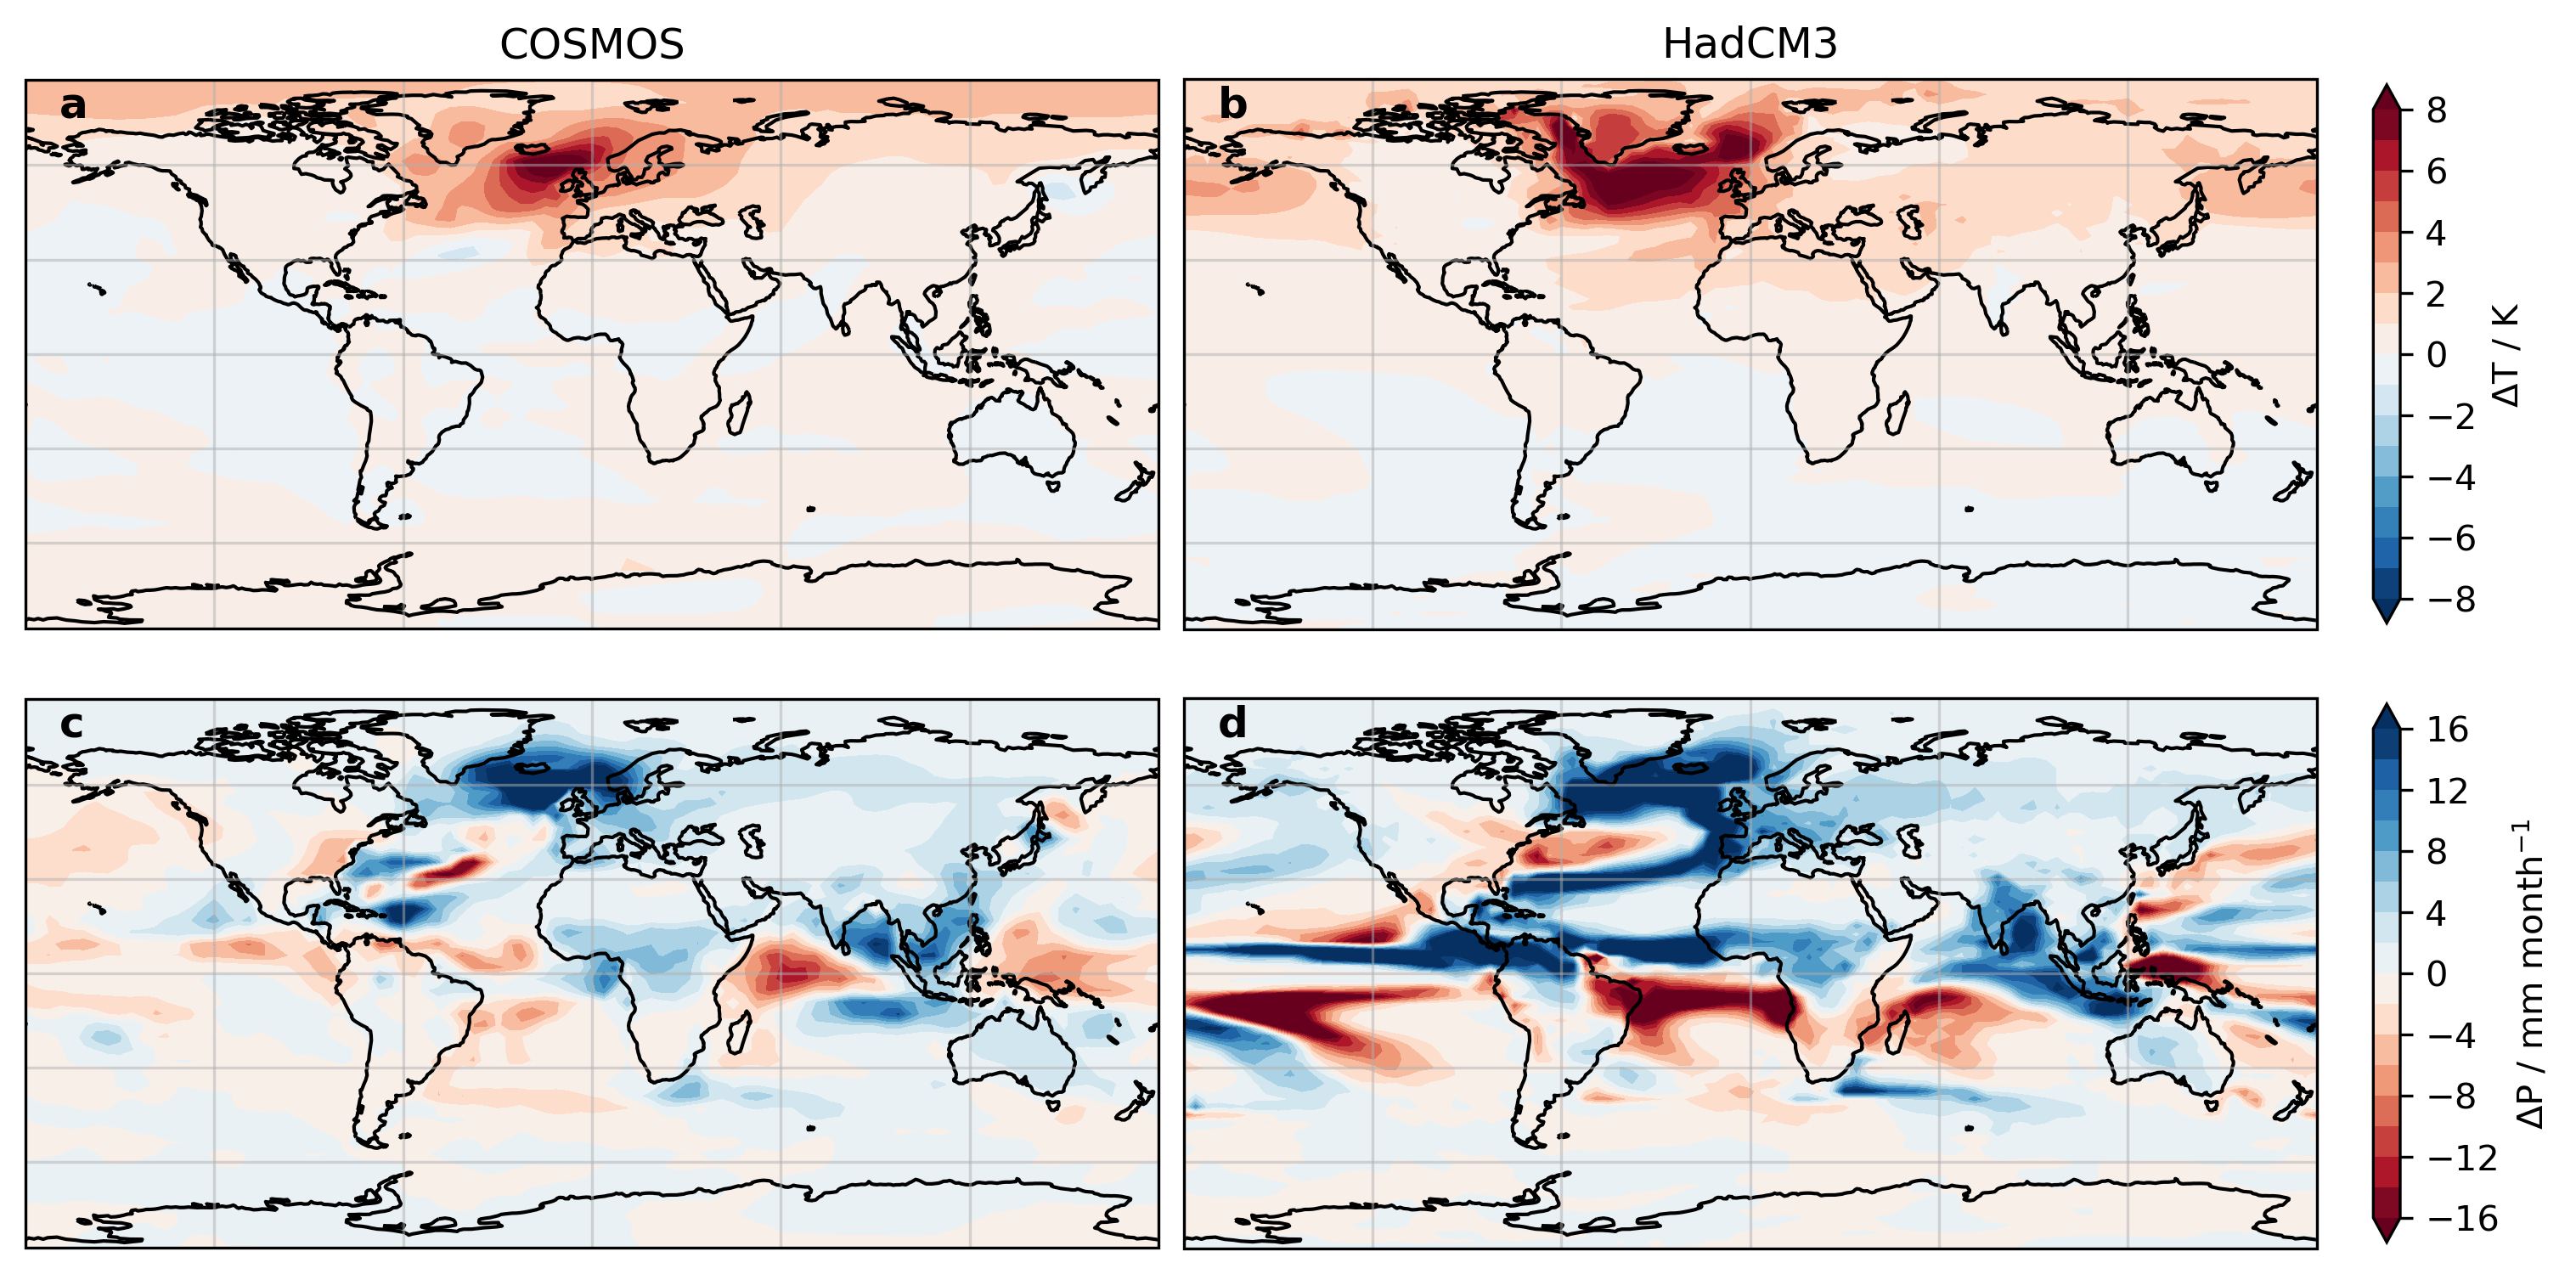

In [9]:
'''Create Figure 2, showing stadial-interstadial difference in precipitation and temperature'''

fig = plt.figure(figsize=(10,5), layout='constrained')

#COSMOS Temperature (a)
cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_Delta_temp,coord=COSMOS_Delta_temp['lon'])
levels=np.arange(-8,9,step=1.0)
ax = fig.add_subplot(221,projection=ccrs.PlateCarree())
ax.gridlines(alpha=0.5)
ax.coastlines()
ax.set_facecolor('gray')
ax.annotate('a', (0.03,0.93), xycoords='axes fraction', size=12, weight='bold', )
ax.set_title('COSMOS')
temp=ax.contourf(cyclic_lon,COSMOS_Delta_temp['lat'],cyclic_data,levels=levels,extend='both',cmap='RdBu_r')

#HadCM3 Temperature (b)
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_Delta_temp,coord=HadCM3_Delta_temp['longitude'])
levels=np.arange(-8,9,step=1.0)
ax = fig.add_subplot(222,projection=ccrs.PlateCarree())
ax.gridlines(alpha=0.5)
ax.coastlines()
ax.set_facecolor('gray')
ax.annotate('b', (0.03,0.93), xycoords='axes fraction', size=12, weight='bold', )
ax.set_title('HadCM3')
temp=ax.contourf(cyclic_lon,HadCM3_Delta_temp['latitude'][1:-1],cyclic_data[1:-1,:],levels=levels,extend='both',cmap='RdBu_r')
colorbar = fig.colorbar(temp, location='right', shrink=0.9, label='$\Delta$T / K')

#COSMOS d18O (c)
cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_Delta_precip,coord=COSMOS_Delta_precip['lon'])
levels=np.arange(-16,18,step=2.0)
ax = fig.add_subplot(223,projection=ccrs.PlateCarree())
ax.gridlines(alpha=0.5)
ax.coastlines()
ax.set_facecolor('gray')
ax.annotate('c', (0.03,0.93), xycoords='axes fraction', size=12, weight='bold', )
precip=ax.contourf(cyclic_lon,COSMOS_Delta_precip['lat'],cyclic_data,levels=levels,extend='both',cmap='RdBu')

#HadCM3 d18O (d)
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_Delta_precip,coord=HadCM3_Delta_precip['longitude'])
levels=np.arange(-16,18,step=2.0)
ax = fig.add_subplot(224,projection=ccrs.PlateCarree())
ax.gridlines(alpha=0.5)
ax.coastlines()
ax.set_facecolor('gray')
ax.annotate('d', (0.03,0.93), xycoords='axes fraction', size=12, weight='bold', )
precip=ax.contourf(cyclic_lon,HadCM3_Delta_precip['latitude'][1:-1],cyclic_data[1:-1,:],levels=levels,extend='both',cmap='RdBu')
colorbar = fig.colorbar(precip, location='right', shrink=0.9, label='$\Delta$P / mm month$^{-1}$')

plt.savefig('Figures/Fig2.pdf')

In [10]:
'''Read model fields for COSMOS d18O'''
COSMOS_Delta_d18O_max = xr.open_dataarray('COSMOS_Data/Max_Delta_d18O.nc') #Stadial-Interstadial difference under narrowest definitions
COSMOS_Delta_d18O_min = xr.open_dataarray('COSMOS_Data/Min_Delta_d18O.nc') #Stadial-Interstadial difference under widest definitions
COSMOS_Delta_d18O = (COSMOS_Delta_d18O_max+COSMOS_Delta_d18O_min)/2 #Take average of max and min values to give central estimate
COSMOS_Delta_d18O_err = (COSMOS_Delta_d18O_max-COSMOS_Delta_d18O_min)/(2*np.sqrt(2)) #Calculate error due to uncertainty in definitions

In [11]:
'''Apply the fractionation correction and conversion from VPDB to VSMOW using the equations of Kim et al. (1997) and 
Coplen et al. (1983) as well as the simulated temperature change in COSMOS. This allows us to calculate d18O_dw-eq changes from the d18O_sp
changes given by Fohlmeister et al. (2023). Note that we perform this calculation separately below using HadCM3 temperatures, and only ever
compare the simulated isotopes in each model to the dripwater equivalent values calculated using temperatures from that same model.'''

alpha_stadial = np.exp(18.03/COSMOS_temp_stadial - 0.03242) #Stadial Fractionation Factor
alpha_interstadial = np.exp(18.03/COSMOS_temp_interstadial - 0.03242) #Interstadial Fractionation Factor
alpha_mean = (alpha_stadial+alpha_interstadial)/2 #Mean Fractionation Factor
#Fractionation Correction for stadial-interstadial difference
correction = 1000*(alpha_stadial-alpha_interstadial)/(alpha_stadial*alpha_interstadial)

corrected_off = np.empty(len(stal))
corrected_std = np.empty(len(stal))
comparison = np.empty(len(stal))
comparison_err = np.empty(len(stal))
for i in range(len(stal)):
    #Calculated the simulated isotopic change (and its error) at the grid cell containing each cave site
    comparison[i] = COSMOS_Delta_d18O.sel(lat=stal['latitude'][i], lon=stal['longitude'][i], method="nearest").values
    comparison_err[i] = COSMOS_Delta_d18O_err.sel(lat=stal['latitude'][i], lon=stal['longitude'][i], method="nearest").values
    site_correction = correction.sel(lat=stal['latitude'][i], lon=stal['longitude'][i], method="nearest").values
    alpha_mean_site = alpha_mean.sel(lat=stal['latitude'][i], lon=stal['longitude'][i], method="nearest").values
    corrected_off[i] = 1.03092*(stal['median_off18O'][i]/alpha_mean_site + site_correction) #Calculate dripwater-equivalent d18O changes
    corrected_std[i] = 1.03092*stal['std_median_off18O'][i]/alpha_mean_site #Calculate error on dripwater-equivalent d18O changes

stal['COSMOS_median_corr_off18O'] = corrected_off
stal['COSMOS_corr_std_off18O'] = corrected_std
stal['COSMOS_comparison'] = comparison
stal['COSMOS_comparison_err'] = comparison_err

In [12]:
'''Read model fields for HadCM3 d18O'''
HadCM3_Delta_d18O_max = xr.open_dataarray('HadCM3_Data/Max_Delta_d18O.nc')#Stadial-Interstadial difference under narrowest definitions
HadCM3_Delta_d18O_min = xr.open_dataarray('HadCM3_Data/Min_Delta_d18O.nc') #Stadial-Interstadial difference under widest definitions
HadCM3_Delta_d18O = (HadCM3_Delta_d18O_max+HadCM3_Delta_d18O_min)/2 #Take average of max and min values to give central estimate
HadCM3_Delta_d18O_err = (HadCM3_Delta_d18O_max-HadCM3_Delta_d18O_min)/(2*np.sqrt(2)) #Calculate error due to uncertainty in definitions

In [13]:
'''Apply the fractionation correction and conversion from VPDB to VSMOW using the equations of Kim et al. (1997) and 
Coplen et al. (1983) as well as the simulated temperature change in HadCM3. This allows us to calculate d18O_dw-eq changes from the d18O_sp
changes given by Fohlmeister et al. (2023). Note that we perform this calculation separately above using COSMOS temperatures, and only ever
compare the simulated isotopes in each model to the dripwater equivalent values calculated using temperatures from that same model.'''

alpha_stadial = np.exp(18.03/HadCM3_temp_stadial - 0.03242) #Stadial Fractionation Factor
alpha_interstadial = np.exp(18.03/HadCM3_temp_interstadial - 0.03242) #Interstadial Fractionation Factor
alpha_mean = (alpha_stadial+alpha_interstadial)/2 #Mean Fractionation Factor
#Fractionation Correction for stadial-interstadial difference
correction = 1000*(alpha_stadial-alpha_interstadial)/(alpha_stadial*alpha_interstadial) 

corrected_off = np.empty(len(stal))
corrected_std = np.empty(len(stal))
comparison = np.empty(len(stal))
comparison_err = np.empty(len(stal))
for i in range(len(stal)):
    #Calculated the simulated isotopic change (and its error) at the grid cell containing each cave site
    comparison[i] = HadCM3_Delta_d18O.sel(lat=stal['latitude'][i],lon=stal['longitude'][i],method="nearest").values
    comparison_err[i] = HadCM3_Delta_d18O_err.sel(lat=stal['latitude'][i],lon=stal['longitude'][i],method="nearest").values
    site_correction = correction.sel(latitude=stal['latitude'][i],longitude=stal['longitude'][i],method="nearest").values
    alpha_mean_site = alpha_mean.sel(latitude=stal['latitude'][i],longitude=stal['longitude'][i],method="nearest").values
    corrected_off[i] = 1.03092*(stal['median_off18O'][i]/alpha_mean_site+site_correction) #Calculate dripwater-equivalent d18O changes
    corrected_std[i] = 1.03092*stal['std_median_off18O'][i]/alpha_mean_site #Calculate error on dripwater-equivalent d18O changes

stal['HadCM3_median_corr_off18O'] = corrected_off
stal['HadCM3_corr_std_off18O'] = corrected_std
stal['HadCM3_comparison'] = comparison
stal['HadCM3_comparison_err'] = comparison_err

In [14]:
'''Calculate regional averages of speleothem d18O changes and the standard deviations within these regions'''
new_region_list = np.array(('Europe','Western North America','Central America', 'South America','Asia','Oceania', 'Other'),dtype='str')
stal_new_region_means=stal[['new_region','HadCM3_median_corr_off18O',
                            'HadCM3_comparison', 'COSMOS_median_corr_off18O', 'COSMOS_comparison']].groupby('new_region').mean()
stal_new_region_std=stal[['new_region','HadCM3_median_corr_off18O',
                          'HadCM3_comparison', 'COSMOS_median_corr_off18O', 'COSMOS_comparison']].groupby('new_region').std()
stal_new_region_means.head()

HadCM3_median_corr_off18O  HadCM3_comparison  \
new_region                                                 
1.0                          0.735831           0.250116   
2.0                          1.247038           0.135371   
3.0                         -0.483943          -0.180171   
4.0                          0.998010           0.046668   
5.0                         -0.731969          -0.210014   

            COSMOS_median_corr_off18O  COSMOS_comparison  
new_region                                                
1.0                          0.662556           0.783492  
2.0                          1.090337          -0.032160  
3.0                         -0.550087          -0.098459  
4.0                          0.960320           0.028011  
5.0                         -0.827969          -0.157642

In [15]:
'''Calculate errors on the observed and simulated regional means, propagating all uncertainties as discussed in SI'''

number = np.empty(7)
for i, new_region in enumerate(np.arange(1.0,8.0,dtype='float')):
    number[i] = np.sum(stal['new_region']==new_region) #number of sites in each region

COSMOS_stad_interstad_err = np.empty(len(new_region_list))
COSMOS_cave_site_err = np.empty(len(new_region_list))
HadCM3_stad_interstad_err = np.empty(len(new_region_list))
HadCM3_cave_site_err = np.empty(len(new_region_list))
for i in range(len(new_region_list)):
    region_stal = stal.where(stal['new_region']==i+1).dropna()
    COSMOS_stad_interstad_err[i] = np.abs(np.mean(region_stal['COSMOS_comparison_err'])) #Due to definitions of stadials and interstadials
    COSMOS_cave_site_err[i] = np.sqrt(np.sum(region_stal['COSMOS_corr_std_off18O']**2))/number[i] #Due to variance within region
    HadCM3_stad_interstad_err[i] = np.abs(np.mean(region_stal['HadCM3_comparison_err'])) #Due to definitions of stadials and interstadials
    HadCM3_cave_site_err[i] = np.sqrt(np.sum(region_stal['HadCM3_corr_std_off18O']**2))/number[i] #Due to variance within region


stal_new_region_std['COSMOS_median_corr_off18O'] = np.sqrt((stal_new_region_std['COSMOS_median_corr_off18O']/np.sqrt(number))**2 \
                                                           + COSMOS_cave_site_err**2)
stal_new_region_std['COSMOS_comparison'] = np.sqrt((stal_new_region_std['COSMOS_comparison']/np.sqrt(number))**2 \
                                                   + COSMOS_stad_interstad_err**2)
stal_new_region_std['HadCM3_median_corr_off18O'] = np.sqrt((stal_new_region_std['HadCM3_median_corr_off18O']/np.sqrt(number))**2 \
                                                           + HadCM3_cave_site_err**2)
stal_new_region_std['HadCM3_comparison'] = np.sqrt((stal_new_region_std['HadCM3_comparison']/np.sqrt(number))**2 \
                                                   + HadCM3_stad_interstad_err**2)

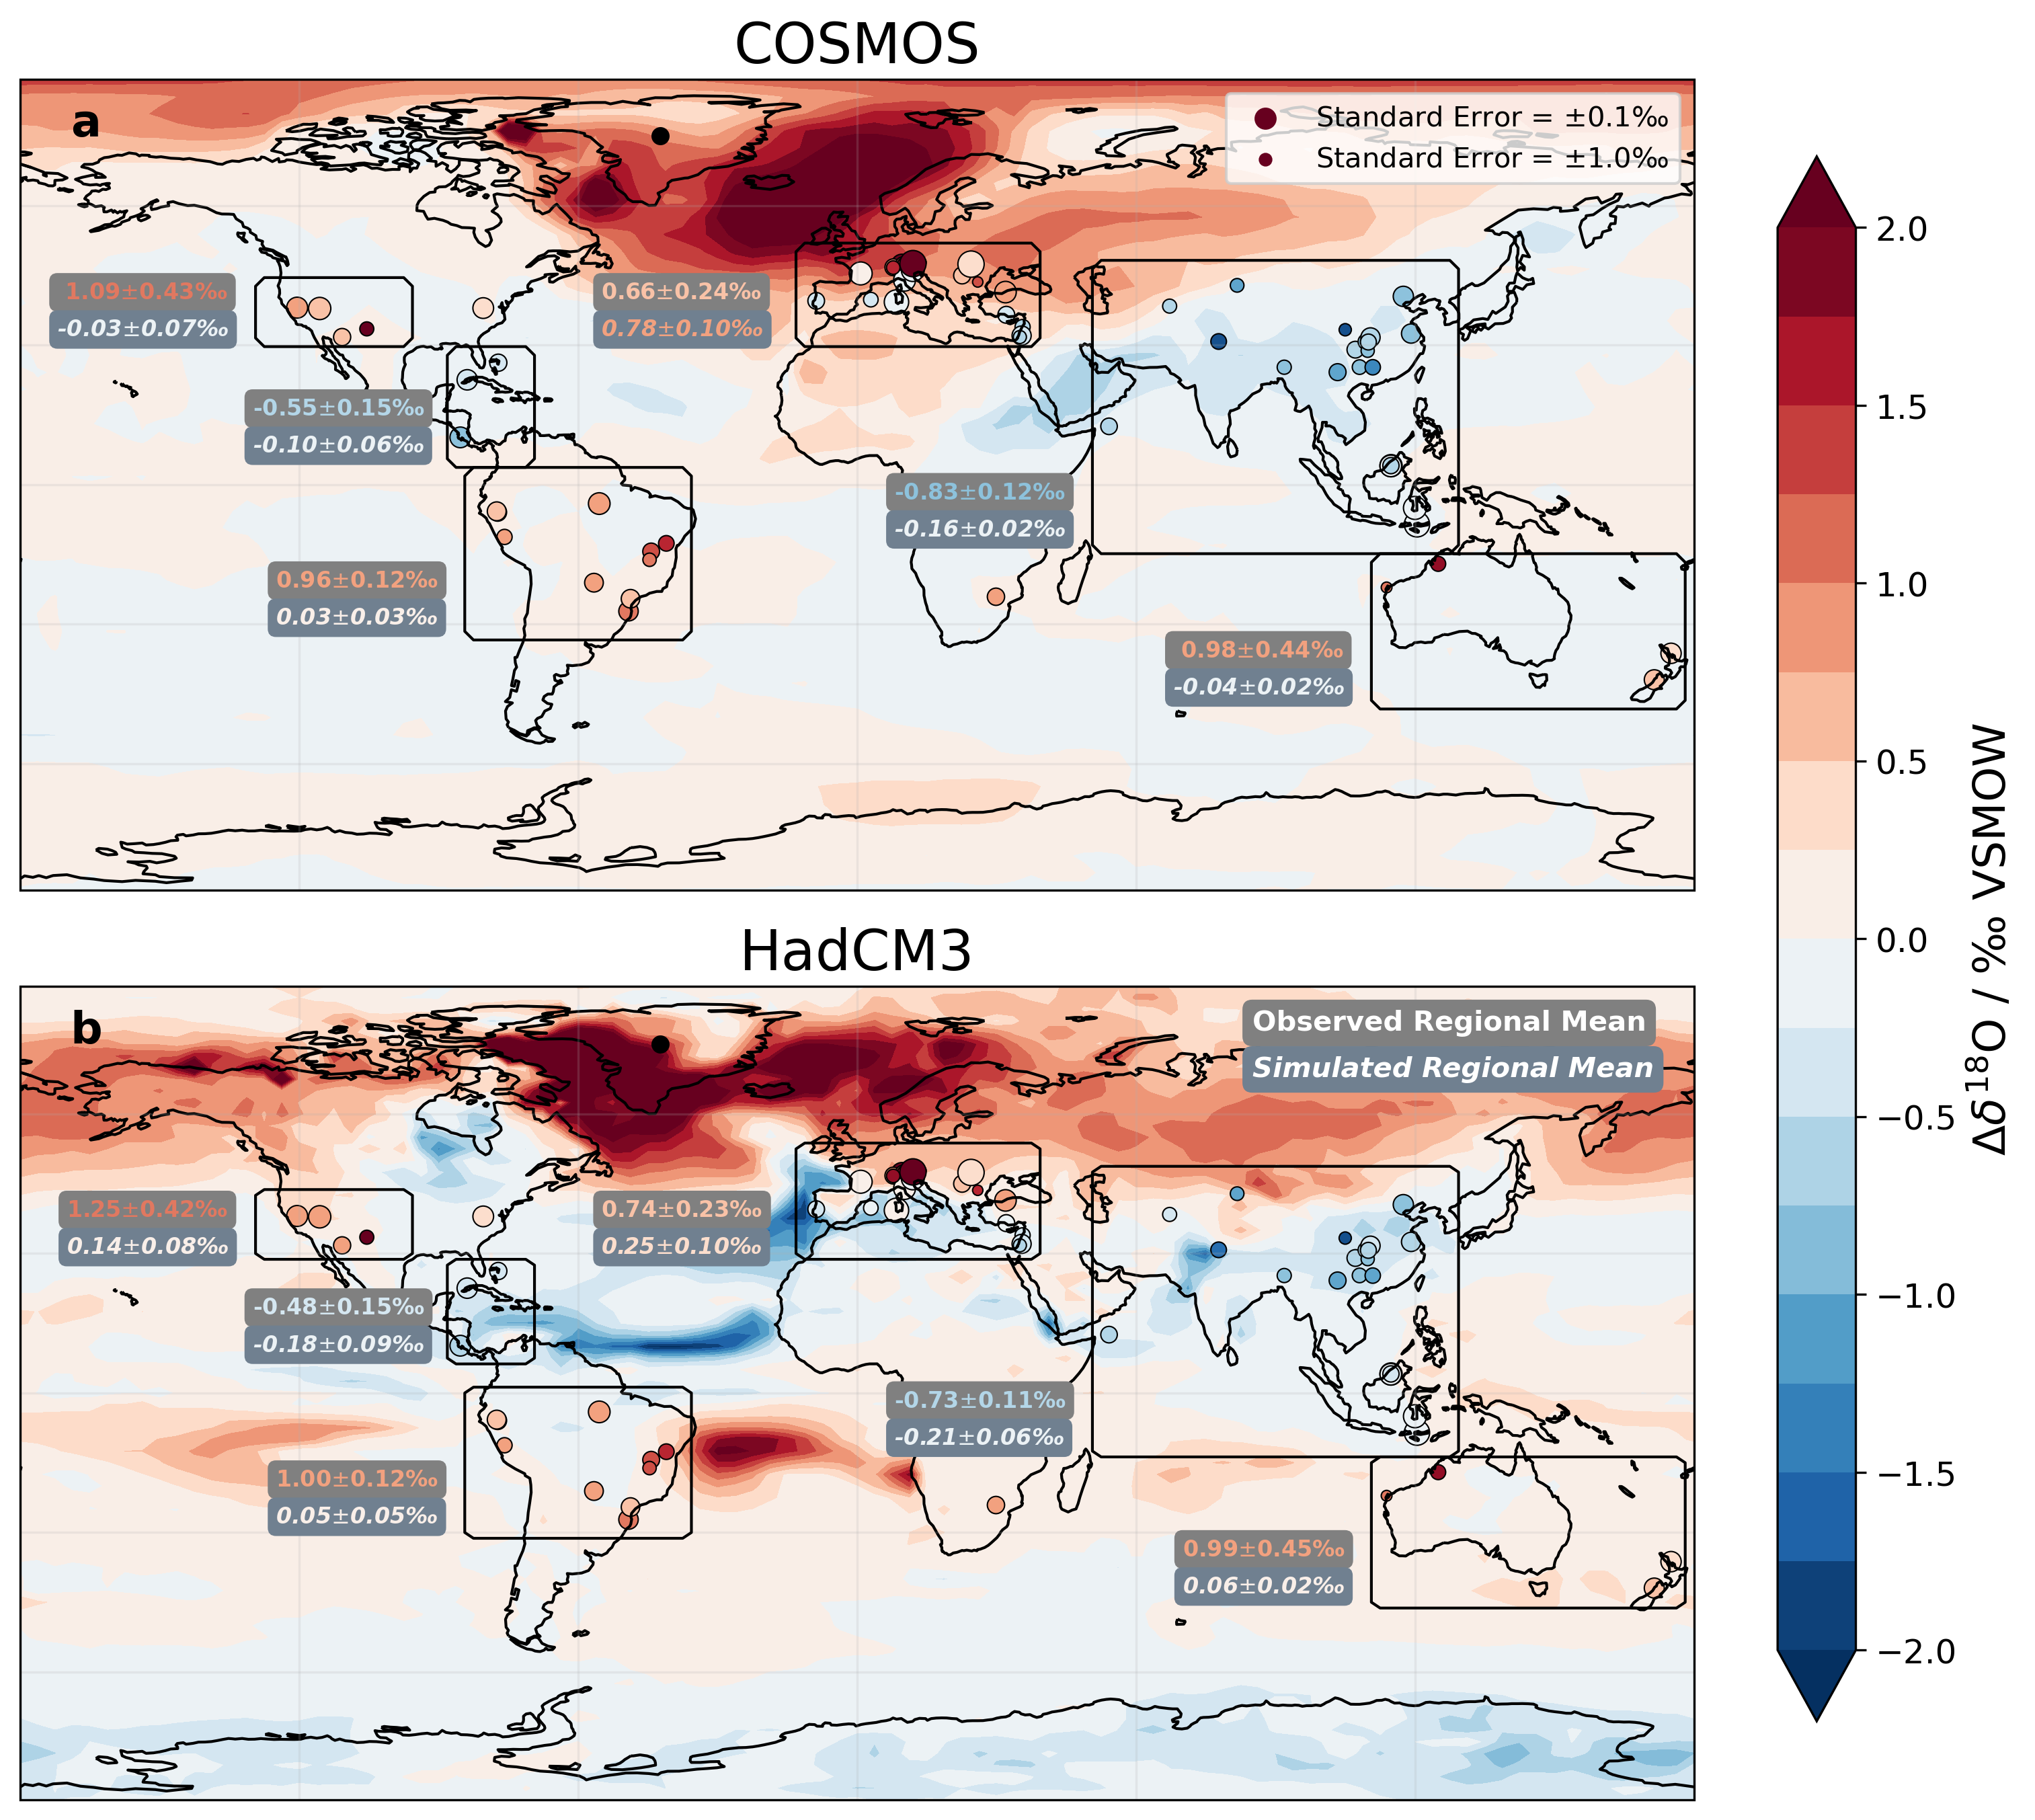

In [16]:
'''Create Figure 3, showing the stadial-interstadial isotopic differences in both models and the speleothems'''

cmap = mpl.colormaps['RdBu_r']
levels=np.arange(-2,2.25,step=0.25)
norm=mpl.colors.BoundaryNorm(boundaries=levels,ncolors=256,extend='both')

fig = plt.figure(figsize=(10,9),layout='constrained')

#COSMOS simulated and observed changes in d18O (a)
ax1 = fig.add_subplot(211,projection=ccrs.PlateCarree(),)
ax1.set_title('COSMOS', size=20)
ax1.annotate('a', (0.03,0.93), xycoords='axes fraction', size=16, weight='bold', )
cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_Delta_d18O,coord=COSMOS_Delta_d18O['lon'])
ax1_contour_map = ax1.contourf(cyclic_lon,COSMOS_Delta_d18O['lat'],cyclic_data,levels=levels,extend='both',cmap=cmap)
ax1.scatter(360-42.3, 75.1, s= 30, color='black')
ax1.scatter(stal['longitude'].values,stal['latitude'],c=stal['COSMOS_median_corr_off18O'], edgecolors='black',
           norm=norm, s=15/np.sqrt(stal['COSMOS_corr_std_off18O']), cmap=cmap, linewidths=0.5)
ax1.coastlines(resolution='110m')
ax1.gridlines(alpha=0.2)

big_example = ax1.scatter(0,0,c=2.1,vmin=-2,vmax=2,cmap=cmap,
                         label='Standard Error = $\pm$0.1‰',s=15/np.sqrt(0.1),zorder=-10)
small_example = ax1.scatter(0,10,c=2.1,vmin=-2,vmax=2,cmap=cmap,
                           label='Standard Error = $\pm$1.0‰',s=15/np.sqrt(1.0),zorder=-10)

EME = COSMOS_Delta_d18O.where((-15<((COSMOS_Delta_d18O['lon']+180)%360)-180)&((((COSMOS_Delta_d18O['lon']+180)%360)-180)<40) \
        &(28<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<53),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(EME,coord=EME['lon'])
map = ax1.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax1.text(-55,40,"%.2f" % stal_new_region_means['COSMOS_median_corr_off18O'].iloc[0] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_median_corr_off18O'].iloc[0]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_median_corr_off18O'].iloc[0])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax1.text(-55,32,"%.2f" % stal_new_region_means['COSMOS_comparison'].iloc[0] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_comparison'].iloc[0]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_comparison'].iloc[0])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

NA = COSMOS_Delta_d18O.where((230<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<265)& \
                      (28<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<45),other=-1000)
map = ax1.contour(NA['lon'],NA['lat'],NA,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax1.text(-172,40," "+"%.2f" % stal_new_region_means['COSMOS_median_corr_off18O'].iloc[1] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_median_corr_off18O'].iloc[1]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_median_corr_off18O'].iloc[1])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax1.text(-172,32,"%.2f" % stal_new_region_means['COSMOS_comparison'].iloc[1] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_comparison'].iloc[1]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_comparison'].iloc[1])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

CA = COSMOS_Delta_d18O.where((270<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<290)& \
                      (5<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<28),other=-1000)
map = ax1.contour(CA['lon'],CA['lat'],CA,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax1.text(-130,15,"%.2f" % stal_new_region_means['COSMOS_median_corr_off18O'].iloc[2] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_median_corr_off18O'].iloc[2]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_median_corr_off18O'].iloc[2])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax1.text(-130,7,"%.2f" % stal_new_region_means['COSMOS_comparison'].iloc[2] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_comparison'].iloc[2]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_comparison'].iloc[2])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

SA = COSMOS_Delta_d18O.where((275<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<325)& \
                      (-32<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<2),other=-1000)
map = ax1.contour(SA['lon'],SA['lat'],SA,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax1.text(-125,-22,"%.2f" % stal_new_region_means['COSMOS_median_corr_off18O'].iloc[3] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_median_corr_off18O'].iloc[3]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_median_corr_off18O'].iloc[3])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax1.text(-125,-30,"%.2f" % stal_new_region_means['COSMOS_comparison'].iloc[3] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_comparison'].iloc[3]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_comparison'].iloc[3])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

AS = COSMOS_Delta_d18O.where((50<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<130)& \
                      (-13<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<48),other=-1000)
map = ax1.contour(AS['lon'],AS['lat'],AS,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax1.text(8,-3,"%.2f" % stal_new_region_means['COSMOS_median_corr_off18O'].iloc[4] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_median_corr_off18O'].iloc[4]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_median_corr_off18O'].iloc[4])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax1.text(8,-11,"%.2f" % stal_new_region_means['COSMOS_comparison'].iloc[4] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_comparison'].iloc[4]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_comparison'].iloc[4])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

OC = COSMOS_Delta_d18O.where((110<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<178)& \
                      (-47<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<-13),other=-1000)
map = ax1.contour(OC['lon'],OC['lat'],OC,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax1.text(68,-37," "+"%.2f" % stal_new_region_means['COSMOS_median_corr_off18O'].iloc[5] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_median_corr_off18O'].iloc[5]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_median_corr_off18O'].iloc[5])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax1.text(68,-45,"%.2f" % stal_new_region_means['COSMOS_comparison'].iloc[5] + '$\pm$' + \
       "%.2f" % stal_new_region_std['COSMOS_comparison'].iloc[5]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['COSMOS_comparison'].iloc[5])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

#HadCM3 simulated and observed changes in d18O (b)
ax2 = fig.add_subplot(212,projection=ccrs.PlateCarree(),)
ax2.set_title('HadCM3', size=20)
ax2.annotate('b', (0.03,0.93), xycoords='axes fraction', size=16, weight='bold', )
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_Delta_d18O,coord=HadCM3_Delta_d18O['lon'])
ax2_contour_map = ax2.contourf(cyclic_lon,HadCM3_Delta_d18O['lat'],cyclic_data,levels=levels,extend='both',cmap=cmap)
ax2.set_extent([-180, 180, HadCM3_Delta_d18O['lat'][-2],HadCM3_Delta_d18O['lat'][1]], ccrs.PlateCarree())
ax2.scatter(stal['longitude'].values,stal['latitude'],c=stal['HadCM3_median_corr_off18O'], edgecolors='black',
           norm=norm, s=15/np.sqrt(stal['HadCM3_corr_std_off18O']), cmap=cmap, linewidths=0.5)
ax2.scatter(360-42.3, 75.1, s= 30, color='black')
ax2.coastlines(resolution='110m')
ax2.gridlines(alpha=0.2)

EME = HadCM3_Delta_d18O.where((-15<((HadCM3_Delta_d18O['lon']+180)%360)-180)&((((HadCM3_Delta_d18O['lon']+180)%360)-180)<40) \
        &(28<HadCM3_Delta_d18O['lat'])&(HadCM3_Delta_d18O['lat']<53),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(EME,coord=EME['lon'])
map = ax2.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.text(-55,38,"%.2f" % stal_new_region_means['HadCM3_median_corr_off18O'].iloc[0] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_median_corr_off18O'].iloc[0]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_median_corr_off18O'].iloc[0])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax2.text(-55,30,"%.2f" % stal_new_region_means['HadCM3_comparison'].iloc[0] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_comparison'].iloc[0]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_comparison'].iloc[0])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

NA = HadCM3_Delta_d18O.where((230<HadCM3_Delta_d18O['lon'])&(HadCM3_Delta_d18O['lon']<265)& \
                      (28<HadCM3_Delta_d18O['lat'])&(HadCM3_Delta_d18O['lat']<45),other=-1000)
map = ax2.contour(NA['lon'],NA['lat'],NA,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.text(-170,38,"%.2f" % stal_new_region_means['HadCM3_median_corr_off18O'].iloc[1] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_median_corr_off18O'].iloc[1]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_median_corr_off18O'].iloc[1])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax2.text(-170,30,"%.2f" % stal_new_region_means['HadCM3_comparison'].iloc[1] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_comparison'].iloc[1]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_comparison'].iloc[1])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

CA = HadCM3_Delta_d18O.where((270<HadCM3_Delta_d18O['lon'])&(HadCM3_Delta_d18O['lon']<290)& \
                      (5<HadCM3_Delta_d18O['lat'])&(HadCM3_Delta_d18O['lat']<28),other=-1000)
map = ax2.contour(CA['lon'],CA['lat'],CA,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.text(-130,17,"%.2f" % stal_new_region_means['HadCM3_median_corr_off18O'].iloc[2] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_median_corr_off18O'].iloc[2]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_median_corr_off18O'].iloc[2])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax2.text(-130,9,"%.2f" % stal_new_region_means['HadCM3_comparison'].iloc[2] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_comparison'].iloc[2]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_comparison'].iloc[2])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

SA = HadCM3_Delta_d18O.where((275<HadCM3_Delta_d18O['lon'])&(HadCM3_Delta_d18O['lon']<325)& \
                      (-32<HadCM3_Delta_d18O['lat'])&(HadCM3_Delta_d18O['lat']<2),other=-1000)
map = ax2.contour(SA['lon'],SA['lat'],SA,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.text(-125,-20,"%.2f" % stal_new_region_means['HadCM3_median_corr_off18O'].iloc[3] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_median_corr_off18O'].iloc[3]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_median_corr_off18O'].iloc[3])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax2.text(-125,-28,"%.2f" % stal_new_region_means['HadCM3_comparison'].iloc[3] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_comparison'].iloc[3]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_comparison'].iloc[3])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

AS = HadCM3_Delta_d18O.where((50<HadCM3_Delta_d18O['lon'])&(HadCM3_Delta_d18O['lon']<130)& \
                      (-13<HadCM3_Delta_d18O['lat'])&(HadCM3_Delta_d18O['lat']<48),other=-1000)
map = ax2.contour(AS['lon'],AS['lat'],AS,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.text(8,-3,"%.2f" % stal_new_region_means['HadCM3_median_corr_off18O'].iloc[4] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_median_corr_off18O'].iloc[4]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_median_corr_off18O'].iloc[4])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax2.text(8,-11,"%.2f" % stal_new_region_means['HadCM3_comparison'].iloc[4] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_comparison'].iloc[4]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_comparison'].iloc[4])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

OC = HadCM3_Delta_d18O.where((110<HadCM3_Delta_d18O['lon'])&(HadCM3_Delta_d18O['lon']<178)& \
                      (-47<HadCM3_Delta_d18O['lat'])&(HadCM3_Delta_d18O['lat']<-13),other=-1000)
map = ax2.contour(OC['lon'],OC['lat'],OC,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.text(70,-35,"%.2f" % stal_new_region_means['HadCM3_median_corr_off18O'].iloc[5] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_median_corr_off18O'].iloc[5]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_median_corr_off18O'].iloc[5])), fontweight='bold',
       bbox=dict(color='grey', boxstyle='round'))
ax2.text(70,-43,"%.2f" % stal_new_region_means['HadCM3_comparison'].iloc[5] + '$\pm$' + \
       "%.2f" % stal_new_region_std['HadCM3_comparison'].iloc[5]+'‰',size=8,
        color=cmap(norm(stal_new_region_means['HadCM3_comparison'].iloc[5])), fontweight='bold', fontstyle='italic',
       bbox=dict(color='slategrey', boxstyle='round'))

obs_example = ax2.text(85, 78, 'Observed Regional Mean',size=10, color='w',
        fontweight='bold', zorder=20, bbox=dict(color='grey', boxstyle='round'))
sim_example = ax2.text(85, 68, 'Simulated Regional Mean',size=10, color='w',
        fontweight='bold', zorder=20, fontstyle='italic', bbox=dict(color='slategrey', boxstyle='round'))

colorbar = fig.colorbar(mappable=ax1_contour_map, ax=[ax1,ax2], shrink=0.90, pad=0.05, location='right', fraction=0.1, )
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label('$\Delta \delta^{18}$O / ‰ VSMOW', fontsize=16)
ax1.legend(handles=(big_example,small_example),)

plt.savefig('Figures/Fig3.pdf')

In [17]:
'''Calculate the ratio of COSMOS simulated to observed changes and the error on this ratio'''

COSMOS_EME_percent = 100*stal_new_region_means['COSMOS_comparison'].iloc[0]/stal_new_region_means['COSMOS_median_corr_off18O'].iloc[0]
COSMOS_EME_percent_err = np.sqrt((stal_new_region_std['COSMOS_median_corr_off18O'].iloc[0]/ \
                                 stal_new_region_means['COSMOS_median_corr_off18O'].iloc[0])**2 \
                                +(stal_new_region_std['COSMOS_comparison'].iloc[0] \
                                  /stal_new_region_means['COSMOS_comparison'].iloc[0])**2)*COSMOS_EME_percent
print('COSMOS Europe / Mediterranean Simulated / Observed = '+str(COSMOS_EME_percent)+' % $\pm$ '+str(COSMOS_EME_percent_err))

COSMOS_NA_percent = 100*stal_new_region_means['COSMOS_comparison'].iloc[1]/stal_new_region_means['COSMOS_median_corr_off18O'].iloc[1]
COSMOS_NA_percent_err = np.sqrt((stal_new_region_std['COSMOS_median_corr_off18O'].iloc[1]/ \
                                 stal_new_region_means['COSMOS_median_corr_off18O'].iloc[1])**2 \
                                +(stal_new_region_std['COSMOS_comparison'].iloc[1] \
                                  /stal_new_region_means['COSMOS_comparison'].iloc[1])**2)*COSMOS_NA_percent
print('COSMOS Western North America Simulated / Observed = '+str(COSMOS_NA_percent)+' % $\pm$ '+str(COSMOS_NA_percent_err))

COSMOS_CA_percent = 100*stal_new_region_means['COSMOS_comparison'].iloc[2]/stal_new_region_means['COSMOS_median_corr_off18O'].iloc[2]
COSMOS_CA_percent_err = np.sqrt((stal_new_region_std['COSMOS_median_corr_off18O'].iloc[2]/ \
                                 stal_new_region_means['COSMOS_median_corr_off18O'].iloc[2])**2 \
                                +(stal_new_region_std['COSMOS_comparison'].iloc[2] \
                                  /stal_new_region_means['COSMOS_comparison'].iloc[2])**2)*COSMOS_CA_percent
print('COSMOS Central America Simulated / Observed = '+str(COSMOS_CA_percent)+' % $\pm$ '+str(COSMOS_CA_percent_err))

COSMOS_AS_percent = 100*stal_new_region_means['COSMOS_comparison'].iloc[4]/stal_new_region_means['COSMOS_median_corr_off18O'].iloc[4]
COSMOS_AS_percent_err = np.sqrt((stal_new_region_std['COSMOS_median_corr_off18O'].iloc[4]/ \
                                 stal_new_region_means['COSMOS_median_corr_off18O'].iloc[4])**2 \
                                +(stal_new_region_std['COSMOS_comparison'].iloc[4] \
                                  /stal_new_region_means['COSMOS_comparison'].iloc[4])**2)*COSMOS_AS_percent
print('COSMOS Asia Simulated / Observed = '+str(COSMOS_AS_percent)+' % $\pm$ '+str(COSMOS_AS_percent_err))

COSMOS Europe / Mediterranean Simulated / Observed = 118.25284823655925 % $\pm$ 45.586175250312145
COSMOS Western North America Simulated / Observed = -2.9495771986698727 % $\pm$ -6.313602822448378
COSMOS Central America Simulated / Observed = 17.898808965615366 % $\pm$ 11.512048307355611
COSMOS Asia Simulated / Observed = 19.03953830485813 % $\pm$ 4.024483935928335


In [18]:
'''Calculate the ratio of HadCM3 simulated to observed changes and the error on this ratio'''

HadCM3_EME_percent = 100*stal_new_region_means['HadCM3_comparison'].iloc[0]/stal_new_region_means['HadCM3_median_corr_off18O'].iloc[0]
HadCM3_EME_percent_err = np.sqrt((stal_new_region_std['HadCM3_median_corr_off18O'].iloc[0]/ \
                                 stal_new_region_means['HadCM3_median_corr_off18O'].iloc[0])**2 \
                                +(stal_new_region_std['HadCM3_comparison'].iloc[0] \
                                  /stal_new_region_means['HadCM3_comparison'].iloc[0])**2)*HadCM3_EME_percent
print('HadCM3 Europe / Mediterranean Simulated / Observed = '+str(HadCM3_EME_percent)+' % $\pm$ '+str(HadCM3_EME_percent_err))

HadCM3_NA_percent = 100*stal_new_region_means['HadCM3_comparison'].iloc[1]/stal_new_region_means['HadCM3_median_corr_off18O'].iloc[1]
HadCM3_NA_percent_err = np.sqrt((stal_new_region_std['HadCM3_median_corr_off18O'].iloc[1]/ \
                                 stal_new_region_means['HadCM3_median_corr_off18O'].iloc[1])**2 \
                                +(stal_new_region_std['HadCM3_comparison'].iloc[1] \
                                  /stal_new_region_means['HadCM3_comparison'].iloc[1])**2)*HadCM3_NA_percent
print('HadCM3 Western North America Simulated / Observed = '+str(HadCM3_NA_percent)+' % $\pm$ '+str(HadCM3_NA_percent_err))

HadCM3_CA_percent = 100*stal_new_region_means['HadCM3_comparison'].iloc[2]/stal_new_region_means['HadCM3_median_corr_off18O'].iloc[2]
HadCM3_CA_percent_err = np.sqrt((stal_new_region_std['HadCM3_median_corr_off18O'].iloc[2]/ \
                                 stal_new_region_means['HadCM3_median_corr_off18O'].iloc[2])**2 \
                                +(stal_new_region_std['HadCM3_comparison'].iloc[2] \
                                  /stal_new_region_means['HadCM3_comparison'].iloc[2])**2)*HadCM3_CA_percent
print('HadCM3 Central America Simulated / Observed = '+str(HadCM3_CA_percent)+' % $\pm$ '+str(HadCM3_CA_percent_err))

HadCM3_AS_percent = 100*stal_new_region_means['HadCM3_comparison'].iloc[4]/stal_new_region_means['HadCM3_median_corr_off18O'].iloc[4]
HadCM3_AS_percent_err = np.sqrt((stal_new_region_std['HadCM3_median_corr_off18O'].iloc[4]/ \
                                 stal_new_region_means['HadCM3_median_corr_off18O'].iloc[4])**2 \
                                +(stal_new_region_std['HadCM3_comparison'].iloc[4] \
                                  /stal_new_region_means['HadCM3_comparison'].iloc[4])**2)*HadCM3_AS_percent
print('HadCM3 Asia Simulated / Observed = '+str(HadCM3_AS_percent)+' % $\pm$ '+str(HadCM3_AS_percent_err))

HadCM3_OC_percent = 100*stal_new_region_means['HadCM3_comparison'].iloc[5]/stal_new_region_means['HadCM3_median_corr_off18O'].iloc[5]
HadCM3_OC_percent_err = np.sqrt((stal_new_region_std['HadCM3_median_corr_off18O'].iloc[5]/ \
                                 stal_new_region_means['HadCM3_median_corr_off18O'].iloc[5])**2 \
                                +(stal_new_region_std['HadCM3_comparison'].iloc[5] \
                                  /stal_new_region_means['HadCM3_comparison'].iloc[5])**2)*HadCM3_OC_percent
print('HadCM3 Oceania Simulated / Observed = '+str(HadCM3_OC_percent)+' % $\pm$ '+str(HadCM3_OC_percent_err))

HadCM3 Europe / Mediterranean Simulated / Observed = 33.99092311625454 % $\pm$ 17.495174080545006
HadCM3 Western North America Simulated / Observed = 10.8553816255505 % $\pm$ 7.4146459588742
HadCM3 Central America Simulated / Observed = 37.22970521841354 % $\pm$ 21.91706175656233
HadCM3 Asia Simulated / Observed = 28.691677291917202 % $\pm$ 8.754390858242035
HadCM3 Oceania Simulated / Observed = 6.174207360653613 % $\pm$ 3.397135381015871


In [19]:
'''Read p values and partial correlations r of d18O_pw with T_pw and P for both models'''

#COSMOS partial correation of d18O_pw and T_pw at constant P
COSMOS_temp_partial_p_values = np.load('COSMOS_Data/temp_partial_p_values.npy') #p values
COSMOS_temp_partial_r_values = np.load('COSMOS_Data/temp_partial_r_values.npy') #partial correlations
#COSMOS partial correation of d18O_pw and P at constant T_pw
COSMOS_precip_partial_p_values = np.load('COSMOS_Data/precip_partial_p_values.npy') #p values
COSMOS_precip_partial_r_values = np.load('COSMOS_Data/precip_partial_r_values.npy') #partial correlations

#HadCM3 partial correation of d18O_pw and T_pw at constant P
HadCM3_temp_partial_p_values = np.load('HadCM3_Data/temp_partial_p_values.npy') #p values
HadCM3_temp_partial_r_values = np.load('HadCM3_Data/temp_partial_r_values.npy') #partial correlations
#HadCM3 partial correation of d18O_pw and P at constant T_pw
HadCM3_precip_partial_p_values = np.load('HadCM3_Data/precip_partial_p_values.npy') #p values
HadCM3_precip_partial_r_values = np.load('HadCM3_Data/precip_partial_r_values.npy') #partial correlations

In [20]:
'''Read model fields for COSMOS d18O of seawater'''
COSMOS_Delta_d18Osw_max = xr.open_dataarray('COSMOS_Data/Max_Delta_d18Osw.nc') #Stadial-Interstadial difference under narrowest definitions
COSMOS_Delta_d18Osw_min = xr.open_dataarray('COSMOS_Data/Min_Delta_d18Osw.nc') #Stadial-Interstadial difference under widest definitions
COSMOS_Delta_d18Osw = (COSMOS_Delta_d18Osw_max+COSMOS_Delta_d18Osw_min)/2 #Take mean of two extremes to give central estimate

In [21]:
'''Read model fields for HadCM3 precipitation-weighted surface winds'''
COSMOS_U10_pw_mean = xr.open_dataarray('COSMOS_Data/Mean_U10_pw.nc') #Mean precipitation-weighted zonal wind over whole run
COSMOS_V10_pw_mean = xr.open_dataarray('COSMOS_Data/Mean_V10_pw.nc') #Mean precipitation-weighted meridional wind over whole run

In [22]:
'''Read model fields for HadCM3 d18O of seawater'''
HadCM3_Delta_d18Osw_max = xr.open_dataarray('HadCM3_Data/Max_Delta_d18Osw.nc') #Stadial-Interstadial difference under narrowest definitions
HadCM3_Delta_d18Osw_min = xr.open_dataarray('HadCM3_Data/Min_Delta_d18Osw.nc') #Stadial-Interstadial difference under widest definitions
HadCM3_Delta_d18Osw = (HadCM3_Delta_d18Osw_max+HadCM3_Delta_d18Osw_min)/2 #Take mean of two extremes to give central estimate

In [23]:
'''Read model fields for HadCM3 precipitation-weighted surface winds'''
HadCM3_U10_pw_mean = xr.open_dataarray('HadCM3_Data/Mean_U10_pw') #Mean precipitation-weighted zonal wind over whole run
HadCM3_V10_pw_mean = xr.open_dataarray('HadCM3_Data/Mean_V10_pw') #Mean precipitation-weighted meridional wind over whole run

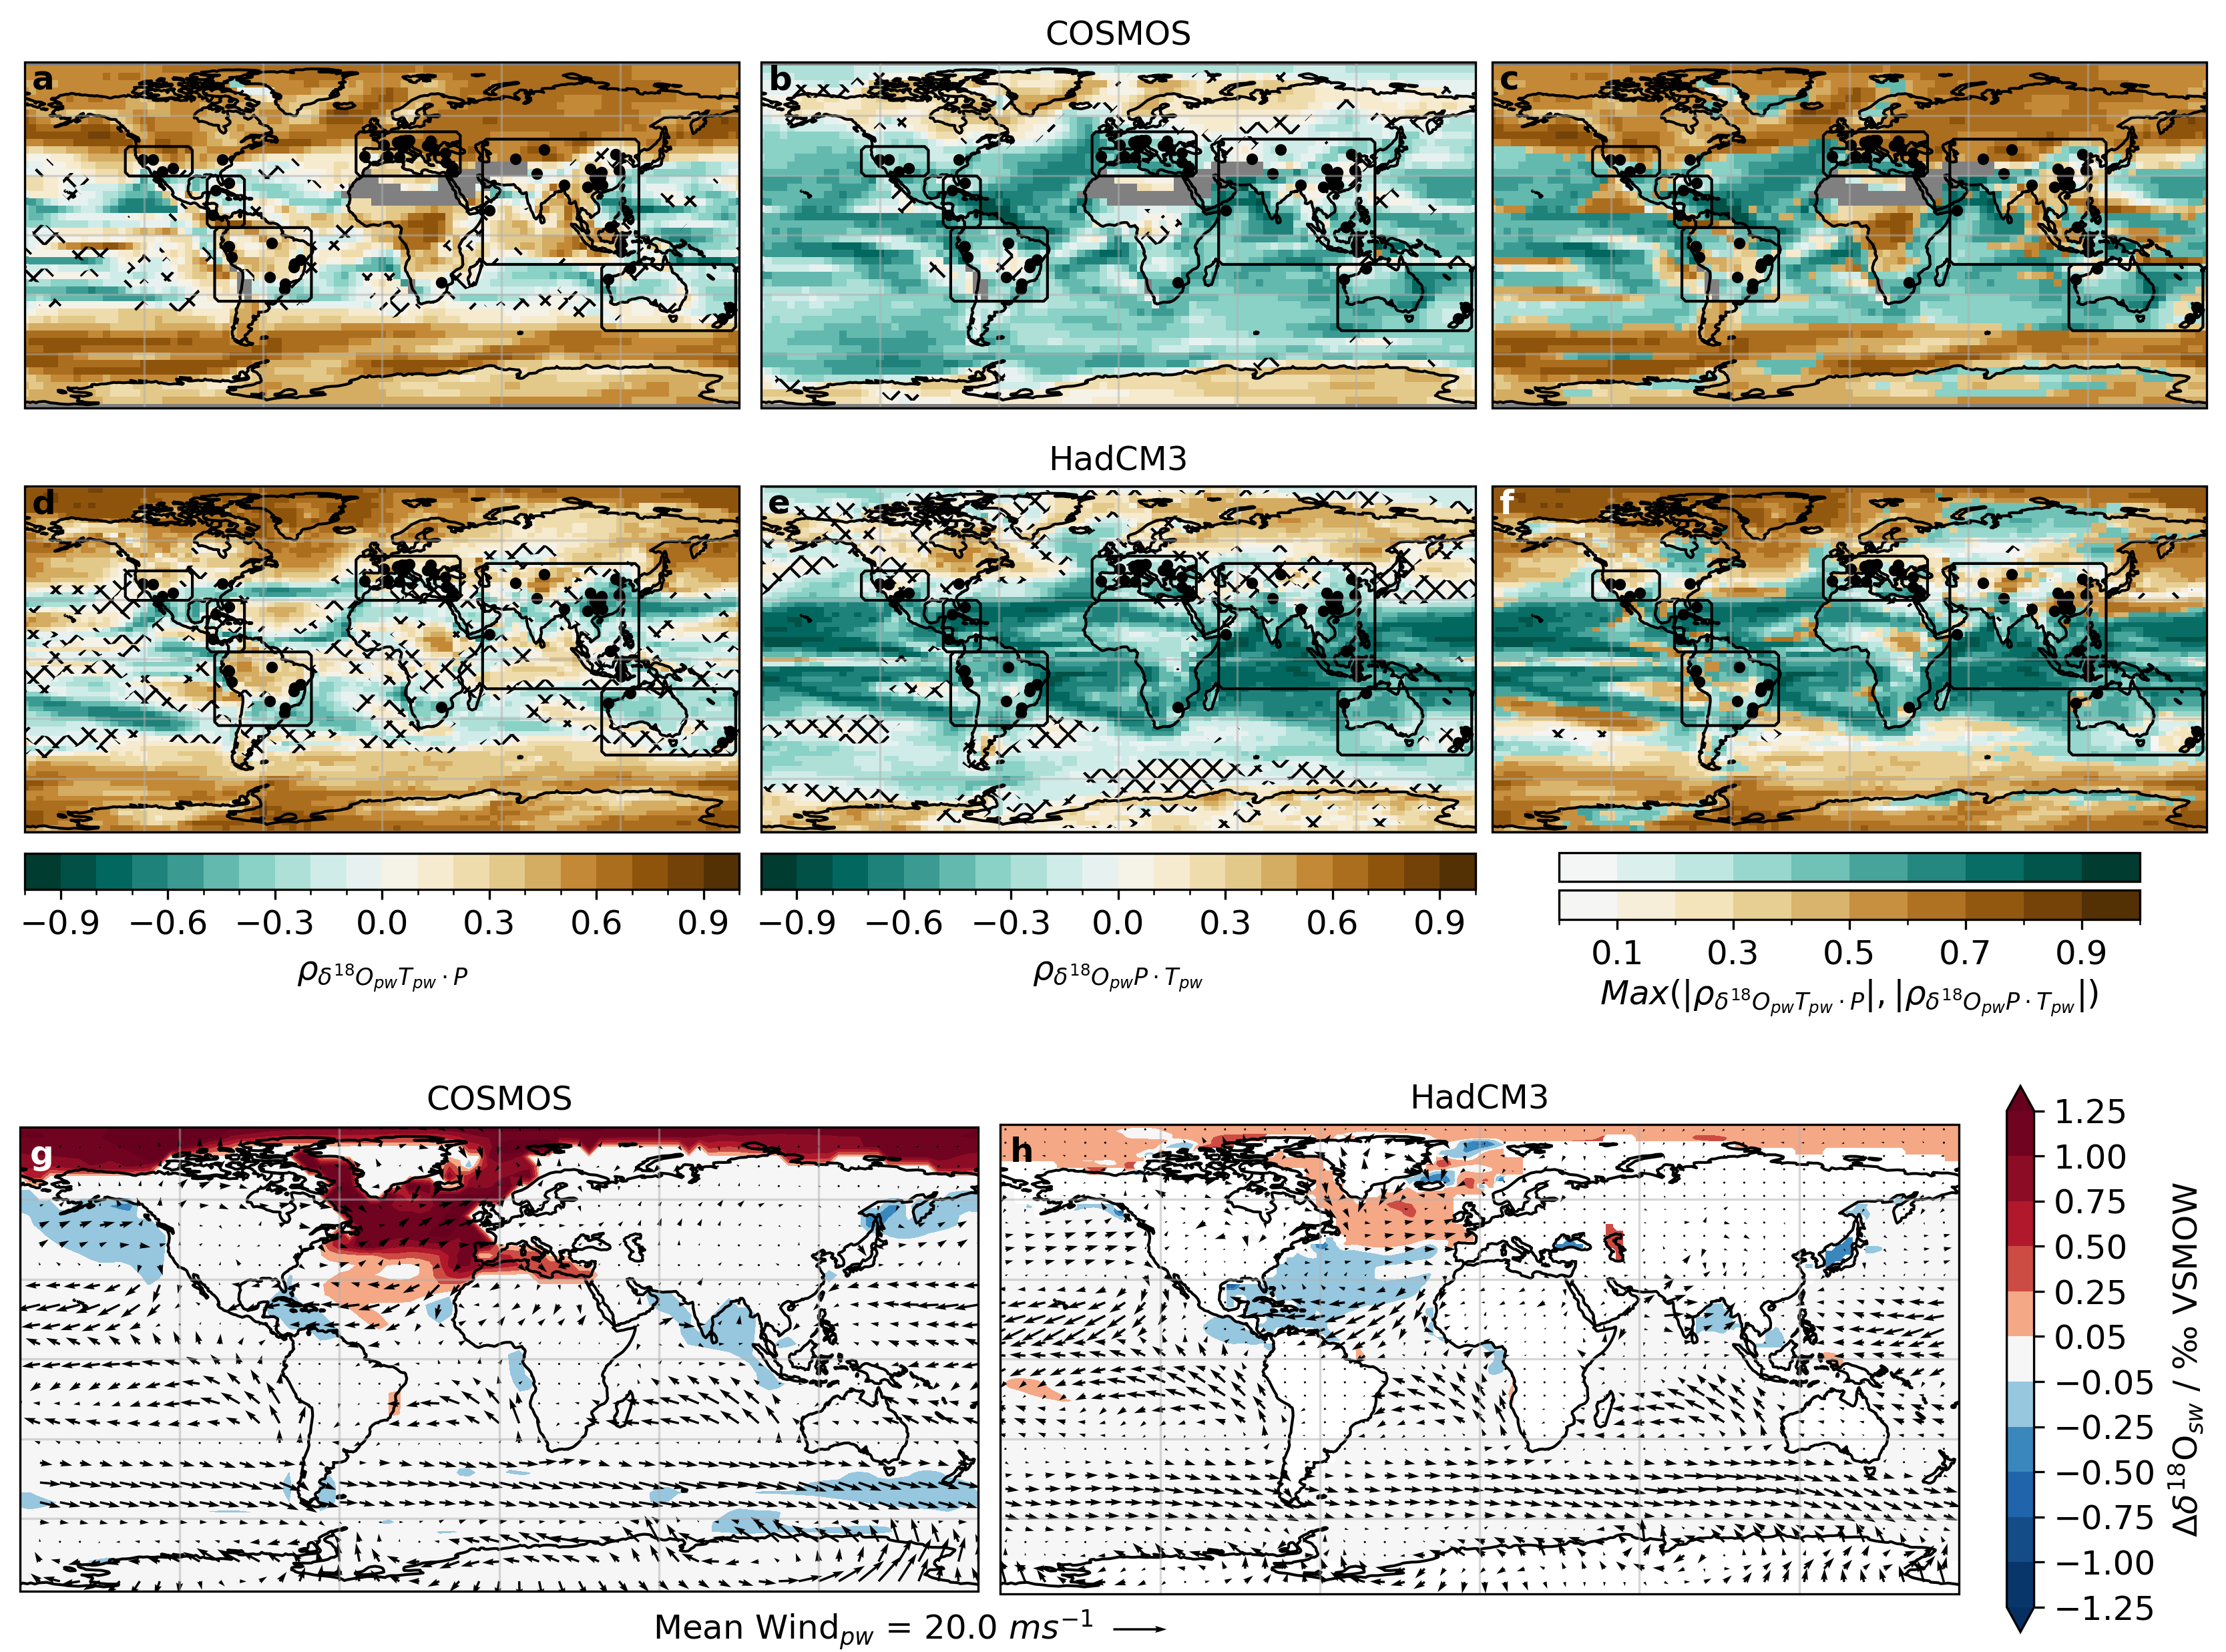

In [24]:
'''Create Figure 4, showing local and remote drivers of isotopic changes'''

fig, (ax1,ax7) = plt.subplots(nrows=2, height_ratios=(1.625,1), figsize=(11,8.25), layout='constrained')
plt.rcParams['hatch.linewidth'] = 1

ax1.remove()
ss1 = ax1.get_subplotspec()
subfig1 = fig.add_subfigure(ss1)
levels=np.arange(-1,1.1,step=0.1)
norm=mpl.colors.BoundaryNorm(boundaries=levels,ncolors=256)

#COSMOS partial correlation between d18O_pw and T_pw at constant P (a)
ax1 = subfig1.add_subplot(231,projection=ccrs.PlateCarree())
ax1.gridlines(alpha=0.5)
ax1.coastlines()
ax1.set_facecolor('gray')
ax1.annotate('a', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', )

cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_temp_partial_r_values,coord=COSMOS_Delta_d18O['lon'])
map=ax1.pcolormesh(cyclic_lon,COSMOS_Delta_d18O['lat'][1:-1],cyclic_data[1:-1,:],cmap='BrBG_r',norm=norm,)
cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_temp_partial_p_values,coord=COSMOS_Delta_d18O['lon'])
ax1.contourf(cyclic_lon,COSMOS_Delta_d18O['lat'][1:-1],cyclic_data[1:-1,:],levels=[-0.01,0.05,1.01],alpha=0,hatches=[None,'xxx'])
ax1.scatter(stal['longitude'].values, stal['latitude'], c='black', s=10)

#COSMOS partial correlation between d18O_pw and P at constant T_pw (b)
ax2 = subfig1.add_subplot(232,projection=ccrs.PlateCarree())
ax2.gridlines(alpha=0.5)
ax2.coastlines()
ax2.set_facecolor('gray')
ax2.annotate('b', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', )
ax2.set_title('COSMOS')

cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_precip_partial_r_values,coord=COSMOS_Delta_d18O['lon'])
map=ax2.pcolormesh(cyclic_lon,COSMOS_Delta_d18O['lat'][1:-1],cyclic_data[1:-1,:],cmap='BrBG_r',norm=norm,)
cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_precip_partial_p_values,coord=COSMOS_Delta_d18O['lon'])
ax2.contourf(cyclic_lon,COSMOS_Delta_d18O['lat'][1:-1],cyclic_data[1:-1,:],levels=[-0.01,0.05,1.01],alpha=0,hatches=[None,'xxx'])
ax2.scatter(stal['longitude'].values, stal['latitude'], c='black', s=10)

#COSMOS greater of partial correlations between d18O_pw and P or T_pw (c)
ax3 = subfig1.add_subplot(233,projection=ccrs.PlateCarree())
ax3.gridlines(alpha=0.5)
ax3.coastlines()
ax3.set_facecolor('gray')
ax3.annotate('c', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', )
greater_r_values = np.where(np.abs(COSMOS_temp_partial_r_values)>np.abs(COSMOS_precip_partial_r_values),
                        np.abs(COSMOS_temp_partial_r_values), -np.abs(COSMOS_precip_partial_r_values))
smaller_p_values = np.where(np.abs(COSMOS_temp_partial_r_values)>np.abs(COSMOS_precip_partial_r_values),
                          COSMOS_temp_partial_p_values, COSMOS_precip_partial_p_values)
cyclic_data, cyclic_lon = add_cyclic_point(greater_r_values,coord=COSMOS_Delta_d18O['lon'])
map = ax3.pcolormesh(cyclic_lon,COSMOS_Delta_d18O['lat'][1:-1],cyclic_data[1:-1,:],cmap='BrBG_r',norm=norm,)
cyclic_data, cyclic_lon = add_cyclic_point(smaller_p_values,coord=COSMOS_Delta_d18O['lon'])
ax3.contourf(cyclic_lon,COSMOS_Delta_d18O['lat'][1:-1],cyclic_data[1:-1,:],levels=[-0.01,0.05,1.01],alpha=0,hatches=[None,'xxx'])
ax3.scatter(stal['longitude'].values, stal['latitude'], c='black', s=10)

#HadCM3 partial correlation between d18O_pw and T_pw at constant P (d)
ax4 = subfig1.add_subplot(234,projection=ccrs.PlateCarree())
ax4.gridlines(alpha=0.5)
ax4.coastlines()
ax4.set_facecolor('gray')
ax4.annotate('d', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', )
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_temp_partial_r_values,coord=HadCM3_Delta_d18O['lon'])
map=ax4.pcolormesh(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],cmap='BrBG_r',norm=norm,)
colorbar = fig.colorbar(map, location='bottom')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_title(r"$\rho_{\delta^{18}O_{pw}T_{pw} \cdot P}$", fontsize=12, y=-3)
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_temp_partial_p_values,coord=HadCM3_Delta_d18O['lon'])
ax4.contourf(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],levels=[-0.01,0.05,1.01],alpha=0,hatches=[None,'xxx'])
ax4.scatter(stal['longitude'].values, stal['latitude'], c='black', s=10)

#HadCM3 partial correlation between d18O_pw and P at constant T_pw (e)
ax5 = subfig1.add_subplot(235,projection=ccrs.PlateCarree())
ax5.gridlines(alpha=0.5)
ax5.coastlines()
ax5.set_facecolor('gray')
ax5.annotate('e', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', )
ax5.set_title('HadCM3')
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_precip_partial_r_values,coord=HadCM3_Delta_d18O['lon'])
map=ax5.pcolormesh(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],cmap='BrBG_r',norm=norm,)
colorbar = fig.colorbar(map, location='bottom')
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_title(r"$\rho_{\delta^{18}O_{pw}P \cdot T_{pw}}$", fontsize=12, y=-3)
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_precip_partial_p_values,coord=HadCM3_Delta_d18O['lon'])
ax5.contourf(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],levels=[-0.01,0.05,1.01],alpha=0,hatches=[None,'xxx'])
ax5.scatter(stal['longitude'].values, stal['latitude'], c='black', s=10)

#HadCM3 greater of partial correlations between d18O_pw and P or T_pw (f)
ax6 = subfig1.add_subplot(236,projection=ccrs.PlateCarree())
ax6.gridlines(alpha=0.5)
ax6.coastlines()
ax6.set_facecolor('gray')
ax6.annotate('f', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', c='white')
levels=np.arange(0,1.1,step=0.1)
norm=mpl.colors.BoundaryNorm(boundaries=levels,ncolors=128)
BrBG_r = mpl.colormaps['BrBG_r']
temp_colormap = mpl.colors.ListedColormap(BrBG_r(np.linspace(0.5, 1.0, 128)))
BrBG = mpl.colormaps['BrBG']
precip_colormap = mpl.colors.ListedColormap(BrBG(np.linspace(0.5, 1.0, 128)))
temp_r_values = np.where(np.abs(HadCM3_temp_partial_r_values)>np.abs(HadCM3_precip_partial_r_values),
                        np.abs(HadCM3_temp_partial_r_values), np.nan)
precip_r_values = np.where(np.abs(HadCM3_temp_partial_r_values)<np.abs(HadCM3_precip_partial_r_values),
                        np.abs(HadCM3_precip_partial_r_values), np.nan)
smaller_p_values = np.where(np.abs(HadCM3_temp_partial_r_values)>np.abs(HadCM3_precip_partial_r_values),
                          HadCM3_temp_partial_p_values, HadCM3_precip_partial_p_values)
cyclic_data, cyclic_lon = add_cyclic_point(temp_r_values,coord=HadCM3_Delta_d18O['lon'])
temp_map = ax6.pcolormesh(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],cmap=temp_colormap,norm=norm,)
cyclic_data, cyclic_lon = add_cyclic_point(precip_r_values,coord=HadCM3_Delta_d18O['lon'])
precip_map = ax6.pcolormesh(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],cmap=precip_colormap,norm=norm,)
cyclic_data, cyclic_lon = add_cyclic_point(smaller_p_values,coord=HadCM3_Delta_d18O['lon'])
ax6.contourf(cyclic_lon,HadCM3_Delta_d18O['lat'][2:-2],cyclic_data[2:-2,:],levels=[-0.01,0.05,1.01],alpha=0,hatches=[None,'xxx'])
temp_colorbar = fig.colorbar(temp_map, location='bottom',fraction=0.075,pad=0.02)
temp_colorbar.set_ticks(ticks=[0.1,0.3,0.5,0.7,0.9],)
temp_colorbar.ax.tick_params(labelsize=12)
temp_colorbar.ax.set_title(r"$Max(|\rho_{\delta^{18}O_{pw}T_{pw} \cdot P}|,|\rho_{\delta^{18}O_{pw}P \cdot T_{pw}}|)$", fontsize=12, y=-3.5)
precip_colorbar = fig.colorbar(precip_map, location='bottom',fraction=0.075)
precip_colorbar.set_ticks(ticks=[],)
precip_colorbar.minorticks_off()
precip_colorbar.ax.tick_params(labelsize=12)
ax6.scatter(stal['longitude'].values, stal['latitude'], c='black', s=10)

#Add boxes showing the six regions to panels a-f
EME = COSMOS_Delta_d18O.where((-15<((COSMOS_Delta_d18O['lon']+180)%360)-180)&((((COSMOS_Delta_d18O['lon']+180)%360)-180)<40) \
        &(28<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<53),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(EME,coord=EME['lon'])
ax1.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax3.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax4.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax5.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax6.contour(cyclic_lon,EME['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)

NA = COSMOS_Delta_d18O.where((230<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<265)& \
                      (28<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<45),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(NA,coord=NA['lon'])
ax1.contour(cyclic_lon,NA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.contour(cyclic_lon,NA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax3.contour(cyclic_lon,NA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax4.contour(cyclic_lon,NA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax5.contour(cyclic_lon,NA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax6.contour(cyclic_lon,NA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)

CA = COSMOS_Delta_d18O.where((270<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<290)& \
                      (5<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<28),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(CA,coord=CA['lon'])
ax1.contour(cyclic_lon,CA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.contour(cyclic_lon,CA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax3.contour(cyclic_lon,CA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax4.contour(cyclic_lon,CA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax5.contour(cyclic_lon,CA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax6.contour(cyclic_lon,CA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)

SA = COSMOS_Delta_d18O.where((275<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<325)& \
                      (-32<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<2),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(SA,coord=SA['lon'])
ax1.contour(cyclic_lon,SA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.contour(cyclic_lon,SA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax3.contour(cyclic_lon,SA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax4.contour(cyclic_lon,SA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax5.contour(cyclic_lon,SA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax6.contour(cyclic_lon,SA['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)

AS = COSMOS_Delta_d18O.where((50<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<130)& \
                      (-13<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<48),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(AS,coord=AS['lon'])
ax1.contour(cyclic_lon,AS['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.contour(cyclic_lon,AS['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax3.contour(cyclic_lon,AS['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax4.contour(cyclic_lon,AS['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax5.contour(cyclic_lon,AS['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax6.contour(cyclic_lon,AS['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)

OC = COSMOS_Delta_d18O.where((110<COSMOS_Delta_d18O['lon'])&(COSMOS_Delta_d18O['lon']<178)& \
                      (-47<COSMOS_Delta_d18O['lat'])&(COSMOS_Delta_d18O['lat']<-13),other=-1000)
cyclic_data, cyclic_lon = add_cyclic_point(OC,coord=OC['lon'])
ax1.contour(cyclic_lon,OC['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax2.contour(cyclic_lon,OC['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax3.contour(cyclic_lon,OC['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax4.contour(cyclic_lon,OC['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax5.contour(cyclic_lon,OC['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)
ax6.contour(cyclic_lon,OC['lat'],cyclic_data,levels=[-500,],colors='k', linestyles='solid', linewidths=1)

ax7.remove()
ss2 = ax7.get_subplotspec()
subfig2 = fig.add_subfigure(ss2)
levels=np.append(np.append(np.arange(-1.25,0,step=0.25),[-0.05,0.05]),np.arange(0.25,1.50,step=0.25))

#COSMOS impact of changes in seawater d18O (g)
ax7 = subfig2.add_subplot(121,projection=ccrs.PlateCarree())
ax7.gridlines(alpha=0.5)
ax7.coastlines()
ax7.annotate('g', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold', c='white')
ax7.set_title('COSMOS')
cyclic_data, cyclic_lon = add_cyclic_point(COSMOS_Delta_d18Osw,coord=COSMOS_Delta_d18Osw['lon'])
ax7_contour_map = ax7.contourf(cyclic_lon,COSMOS_Delta_d18Osw['lat'],cyclic_data,levels=levels,extend='both',cmap=cmap, zorder=-10,
                              norm=mpl.colors.SymLogNorm(linthresh=0.05,linscale=0.1))
ax7_quiver = ax7.quiver(COSMOS_U10_pw_mean['lon'][np.arange(len(COSMOS_U10_pw_mean['lon']),step=2)],
                        COSMOS_U10_pw_mean['lat'][np.arange(len(COSMOS_U10_pw_mean['lat']),step=2)],
                        COSMOS_U10_pw_mean[np.arange(len(COSMOS_U10_pw_mean['lat']),step=2),
                        np.arange(len(COSMOS_U10_pw_mean['lon']),step=2)],
                        COSMOS_V10_pw_mean[np.arange(len(COSMOS_U10_pw_mean['lat']),step=2),
                        np.arange(len(COSMOS_U10_pw_mean['lon']),step=2)],
                        scale_units='inches',scale=75)

#HadCM3 impact of changes in seawater d18O (h)
ax8 = subfig2.add_subplot(122,projection=ccrs.PlateCarree())
ax8.gridlines(alpha=0.5)
ax8.coastlines()
ax8.annotate('h', (0.01,0.92), xycoords='axes fraction', size=12, weight='bold')
ax8.set_title('HadCM3')
cyclic_data, cyclic_lon = add_cyclic_point(HadCM3_Delta_d18Osw,coord=HadCM3_Delta_d18Osw['longitude'])
ax8_contour_map = ax8.contourf(cyclic_lon,HadCM3_Delta_d18Osw['latitude'][1:-1],cyclic_data[1:-1,:],
                                      levels=levels,extend='both',cmap=cmap,zorder=-10,
                              norm=mpl.colors.SymLogNorm(linthresh=0.05,linscale=0.1),)
ax8_quiver = ax8.quiver(HadCM3_V10_pw_mean['longitude_1'][np.arange(len(HadCM3_U10_pw_mean['longitude_1']),step=2)],
                        HadCM3_V10_pw_mean['latitude_1'][np.arange(1,len(HadCM3_U10_pw_mean['latitude_1'])-1,step=2)],
                        HadCM3_U10_pw_mean[np.arange(1,len(HadCM3_U10_pw_mean['latitude_1'])-1,step=2),
                        np.arange(len(HadCM3_U10_pw_mean['longitude_1']),step=2)],
                        HadCM3_V10_pw_mean[np.arange(1,len(HadCM3_U10_pw_mean['latitude_1'])-1,step=2),
                        np.arange(len(HadCM3_U10_pw_mean['longitude_1']),step=2)],
                        scale_units='inches',scale=75,)
colorbar1 = fig.colorbar(mappable=ax8_contour_map, shrink=0.9, location='right', )
colorbar1.ax.tick_params(labelsize=12)
colorbar1.set_ticks(ticks=[-1.25,-1.0,-0.75,-0.50,-0.25,-0.05,0.05,0.25,0.50,0.75,1.0,1.25],)
colorbar1.set_label('$\Delta \delta^{18}$O$_{sw}$ / ‰ VSMOW', fontsize=12)
quiverkey1 = ax7.quiverkey(ax7_quiver, 0.5, 0.025, 20.0, 'Mean Wind$_{pw}$ = 20.0 $ms^{-1}$',
                           labelpos="W", coordinates='figure', fontproperties={'size':12})

plt.savefig('Figures/Fig4.pdf', bbox_inches='tight')